In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import Counter
from tqdm import tqdm
import re, random, itertools
from pySankey import sankey

In [2]:
plt.ion()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
n = 2
plt.rc('axes', linewidth=n)
ticksSizeMajor = 10
ticksSizeMinor = 5
ticksWidth = n
ticksLabelSize = 20
axisLabelSize = 25
titleSize = 30
legendSize = 20

In [ ]:
path_input = r'/my/path/input/'
path_output = r'/my/path/output/'

# 1 - Read datasets

- `author2paper.csv`
- `ExtraPapers_from_authors.csv`
- `papersNeuroAI_minRef10_minImp10_from1970.csv` (obtained with code `1 - dataset_preparation.ipynb`)
- `papersNeuro_minRef10_minImp10_from1970.csv` (obtained with code `1 - dataset_preparation.ipynb`)
- `collabNet_nodes.csv` (obtained with code `1 - dataset_preparation.ipynb`, also on Zenodo's repo)
- `collabNet.csv` (obtained with code `1 - dataset_preparation.ipynb`, also on Zenodo's repo)
- `collabNet_edges_timeagg.csv` (obtained with code `1 - dataset_preparation.ipynb`)

## 1.1 - Egocentered $\mathcal{P}\cap AI$ dataset

In [3]:
# only papers in qeryLevel=0, published since 1970 and that have at least 10 references and 10 impacts
papersNeuroAI = pd.read_csv(f'{path_input}papersNeuroAI_minRef10_minImp10_from1970.csv', sep=';')
len(papersNeuroAI)

26374

## 1.2 - Egocentered $\mathcal{P}\cap \overline{AI}$ dataset

In [4]:
# only papers in qeryLevel=0, published since 1970 and that have at least 10 references and 10 impacts
papersNeuro = pd.read_csv(f'{path_input}papersNeuro_minRef10_minImp10_from1970.csv', sep=';')
len(papersNeuro)

829317

## 1.3 - Concatenate the two filtered files of papers

In [5]:
allpapers_Ql0 = pd.concat([papersNeuroAI,papersNeuro]).reset_index(drop=True)
allpapers_Ql0['authors'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_Ql0['authors']] # to avoid the double apparitions
allpapers_Ql0['journal_title'] = [list(set(eval(i)))[0] if i!='-1' else -1 for i in allpapers_Ql0['journal_title']] # idem
allpapers_Ql0['wos_domains'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_Ql0['wos_domains']] # idem
allpapers_Ql0['wos_domains_agg'] = allpapers_Ql0['wos_domains'].apply(lambda x: list(set([i.split(', ')[0] for i in x])) if x!=-1 else -1)
allpapers_Ql0['keywordsIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_Ql0['keywordsIA']] # idem
allpapers_Ql0['classIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_Ql0['classIA']] # idem
allpapers_Ql0                                                              

,id,queryLevel,publicationYear,idJournal,authors,journal_title,wos_domains,isIA,keywordsIA,classIA,wos_domains_agg
0,2617245985,0,2017,45693802,"[3024761849, 2619442247]",NEUROCOMPUTING,"[Computer Science, Artificial Intelligence]",1,"[autoencoder, dimensionality reduction]","[cluster analysis, deep learning]",[Computer Science]
1,2021655074,0,2006,140962798,"[2145260682, 2835622326]",NEURAL PROCESSING LETTERS,"[Computer Science, Artificial Intelligence]",1,"[backpropagation, perceptrons]",[neural networks],[Computer Science]
2,1790968754,0,2015,207023548,"[2995834608, 2891704168, 2798335766, 2651595071]",NEURAL COMPUTATION,"[Computer Science, Artificial Intelligence, Ne...",1,[principal component analysis],[cluster analysis],"[Neurosciences, Computer Science]"
3,2067792927,0,2004,5555990,"[1907317825, 2569059621, 2810474215]",JOURNAL OF NEUROSCIENCE,[Neurosciences],1,[mycin],[AI general],[Neurosciences]
4,2076181669,0,2009,38337076,"[2747958979, 3025919237, 2109544006, 301823171...",CLINICAL NEUROPHYSIOLOGY,"[Clinical Neurology, Neurosciences]",1,[f score],[NLP],"[Clinical Neurology, Neurosciences]"
...,...,...,...,...,...,...,...,...,...,...,...
855686,2772434918,0,2017,185208586,"[2775248611, 2698039717, 2676369288, 277171484...",CELL DEATH & DISEASE,[Cell Biology],0,-1,-1,[Cell Biology]
855687,2080374764,0,2014,59392935,"[2781203175, 2996824428, 2565784013, 261729982...",TRANSLATIONAL STROKE RESEARCH,"[Clinical Neurology, Neurosciences]",0,-1,-1,"[Clinical Neurology, Neurosciences]"
855688,1598029808,0,2002,170217976,"[2724792729, 2528151317, 2618669055]",PROGRESS IN BRAIN RESEARCH,[Neurosciences],0,-1,-1,[Neurosciences]
855689,2030043122,0,2008,103225281,"[2161995493, 2653812806, 2918078508, 285482286...",NEUROIMAGE,"[Radiology, Nuclear Medicine & Medical Imaging...",0,-1,-1,"[Radiology, Neuroimaging, Neurosciences]"


## 1.4 - Load all other papers published by the authors in the authors' database (`queryLevel=2`)

In [6]:
allpapers_Ql2 = pd.read_csv(f'{path_input}ExtraPapers_from_authors.csv', sep=';').fillna(-1)
allpapers_Ql2['wos_domains'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_Ql2['wos_domains']]
allpapers_Ql2['wos_domains_agg'] = allpapers_Ql2['wos_domains'].apply(lambda x: list(set([i.split(', ')[0] for i in x])) if x!=-1 else -1)
allpapers_Ql2['journal_title'] =  allpapers_Ql2['journal_title'].apply(lambda x: list(set(eval(x)))[0] if x!=-1 else -1)
allpapers_Ql2['keywordsIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_Ql2['keywordsIA']]
allpapers_Ql2['classIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_Ql2['classIA']] 
allpapers_Ql2

,id,publicationYear,title,idJournal,queryLevel,journal_title,wos_domains,isIA,keywordsIA,classIA,wos_domains_agg
0,1984623903,1981,"""F&#x00FC;nf neue Arten der Gattung Halacarus ...",4078192,2,ZOOLOGICA SCRIPTA,"[Zoology, Evolutionary Biology]",0,-1,-1,"[Zoology, Evolutionary Biology]"
1,1984624469,2014,"""Ultracompact three-dimensional tubular conduc...",143846845,2,NANO LETTERS,"[Chemistry, Multidisciplinary, Chemistry, Phys...",0,-1,-1,"[Chemistry, Materials Science, Nanoscience & N..."
2,1984630132,2000,"""Enhanced dechlorination of Aroclor 1242 in an...",52566953,2,WATER RESEARCH,"[Engineering, Environmental, Water Resources, ...",0,-1,-1,"[Water Resources, Engineering, Environmental S..."
3,1984632460,1996,"""NEST PREDATION AND AVIAN LIFE-HISTORY EVOLUTI...",122176235,2,AMERICAN NATURALIST,"[Ecology, Evolutionary Biology]",0,-1,-1,"[Ecology, Evolutionary Biology]"
4,1984633284,2017,"""On the Matter of Suffering: Derek Parfit and ...",56047584,2,CRIMINAL LAW AND PHILOSOPHY,[Law],0,-1,-1,[Law]
...,...,...,...,...,...,...,...,...,...,...,...
24330847,2523645934,2013,"""Reproductive outcomes after bariatric surgery""",-1,2,-1,-1,0,-1,-1,-1
24330848,2523663736,2014,"""Nano-engineered PLLA based biomaterial drives...",68700368,2,JOURNAL OF TISSUE ENGINEERING AND REGENERATIVE...,"[Biotechnology & Applied Microbiology, Cell & ...",0,-1,-1,"[Biotechnology & Applied Microbiology, Cell & ..."
24330849,2523695446,2016,"""Executive functioning in autism spectrum diso...",-1,2,-1,-1,0,-1,-1,-1
24330850,2523696321,2006,"""Surr&#x00E9;nalectorme unilat&#x00E9;rale et ...",198822128,2,-1,-1,0,-1,-1,-1


## 1.5 - Load the linkfile authors-papers (including all papers with `queyLevel=0` and `queryLevel=2`)

In [7]:
allAuthors_Ql0_papers = pd.read_csv(f'{path_input}author2paper.csv', sep=',')
allAuthors_Ql0_papers.drop_duplicates(inplace=True)
allAuthors_Ql0_papers

,authorId,paperId
0,2951562659,285
1,2535012878,348
2,2482451074,348
3,2060325654,527
4,2746639708,662
...,...,...
53855474,2785152602,3035763607
53855475,2852722787,3035763695
53855476,2650729909,3035763695
53855477,2159918643,3035763702


## 1.6 - Read the collaboration network databases

In [8]:
authorsInPapers = pd.read_csv(f'{path_input}collabNet_nodes.csv', sep=';')
authorsInPapers

,authorId,name,affiliation,queryLevel,nb_publi_neuro,AIscore_neuro,nb_publi_all,AIscore_all,beginYear,wos_begin,lastYear,wos_last,deltaYear
0,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0.0,1.0,0.0,6,0.0,1997.0,"[['Multidisciplinary Sciences'], ['Cell Biolog...",2012.0,[['Cell Biology']],15.0
1,2505675405,A. A. A. Manik J. Djelantik,193662353,0.0,2.0,0.0,11,0.0,2016.0,"[['Neuroimaging', 'Psychiatry', 'Clinical Neur...",2019.0,"[['Social Issues', 'Social Sciences', 'Psychol...",3.0
2,2806045187,A.A.A. Pradhan,5023651,0.0,1.0,0.0,1,0.0,2006.0,[['Neurosciences']],2006.0,[['Neurosciences']],0.0
3,2974182613,A. A. Aarnisalo,NONE,0.0,1.0,0.0,2,0.0,1993.0,[['Endocrinology & Metabolism']],1995.0,[['Neurosciences']],2.0
4,2991992674,A A Abdel-Latif,25041050,0.0,3.0,0.0,8,0.0,1977.0,[['Biochemistry & Molecular Biology']],1991.0,"[['Cell Biology', 'Endocrinology & Metabolism'...",14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0.0,1.0,0.0,1,0.0,2012.0,"[['Behavioral Sciences', 'Psychiatry', 'Clinic...",2012.0,"[['Behavioral Sciences', 'Psychiatry', 'Clinic...",0.0
1290137,3022633000,Е Е Garanina,21203515,0.0,1.0,0.0,1,0.0,2016.0,"[['Rehabilitation', 'Clinical Neurology']]",2016.0,"[['Rehabilitation', 'Clinical Neurology']]",0.0
1290138,2688406403,Мikhail Pashenkov,NONE,0.0,1.0,0.0,1,0.0,2016.0,"[['Neurosciences', 'Immunology']]",2016.0,"[['Neurosciences', 'Immunology']]",0.0
1290139,2495571327,І. L. Popovych,149851306,0.0,1.0,0.0,1,0.0,2014.0,"[['Neurosciences', 'Physiology']]",2014.0,"[['Neurosciences', 'Physiology']]",0.0


In [8]:
collabNet = pd.read_csv(f'{path_input}collabNet.csv', sep=';')
collabNet_timeagg = pd.read_csv(f'{path_input}collabNet_edges_timeagg.csv', sep=';')
G = ig.Graph.DataFrame(collabNet_timeagg, directed=False)

### 1.6.1 - Select the authors depending on their first year of publication and their career
- keep only people that have begun to publish at least in 1940 having a duration of career up to 50 years
- Period up to 2019
- keep only people that have at least 3 publications: boarder effect in $f_{AI}=1$ whose high propensity could be explained by authors with only one publication, such as interns, post-doc, PhD students, etc.

In [10]:
len(authorsInPapers[authorsInPapers['AIscore_all']>0])/len(authorsInPapers)

0.15763935879876695

In [32]:
authorsInPapers_sub = authorsInPapers[(authorsInPapers['beginYear']>=1940) & 
                                      (authorsInPapers['deltaYear']<=50) &
                                      (authorsInPapers['nb_publi_all']>=3)]

In [21]:
sub_collabNet = collabNet[collabNet['author1'].isin(authorsInPapers_sub['authorId'])
                         & collabNet['author2'].isin(authorsInPapers_sub['authorId'])]

In [22]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

In [44]:
print(len(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']==0]))
print(len(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']>0]), 
      min(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']>0]['AIscore_all']),
      max(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']<1]['AIscore_all']))
print(len(authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>0)&
                              (authorsInPapers_sub['AIscore_all']<0.5)]))
print(len(authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>=0.5)&
                              (authorsInPapers_sub['AIscore_all']<1)]))
print(len(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']==1]))
print(len(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']>0])/len(authorsInPapers_sub))

697749
188325 0.0004332755632582 0.9615384615384616
182925
4977
423
0.2125386818708144


<b>Output</b>

697749

188325 0.0004332755632582 0.9615384615384616

182925

4977

423

0.2125386818708144

# 2 - Decompositon of the distribution of $f_{AI}$ in quartile

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ] [8.11849e+05 2.77690e+04 1.43690e+04 6.37900e+03 5.54900e+03 5.63500e+03
 4.81000e+03 1.51900e+03 1.95900e+03 8.36000e+02 1.63400e+03 9.39000e+02
 4.48000e+02 9.33000e+02 2.34000e+02 3.75000e+02 2.72000e+02 9.70000e+01
 4.40000e+01 4.24000e+02]


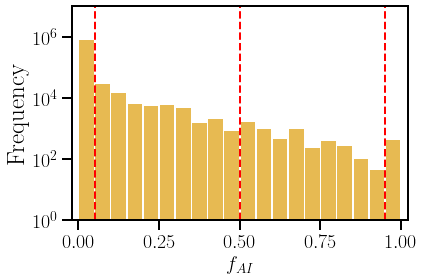

In [123]:
cmap = plt.cm.tab20b.colors
nbins = 20
n_slices = 4

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
bins = np.linspace(0,1,nbins)
values, bins, patches = plt.hist(authorsInPapers_sub['AIscore_all'], bins=nbins, rwidth=0.9, color=cmap[10])
print(bins, values)
quantile = [bins[0], bins[1], bins[10], bins[19]]
for q in quantile[1:]:
    plt.axvline(q,color='red',linewidth=2,linestyle='--')
plt.ylabel(r'Frequency', fontsize=axisLabelSize)
plt.xlabel(r'$f_{AI}$', fontsize=axisLabelSize-5)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
plt.yscale('log')
plt.xlim(-0.02,1.02)
plt.ylim(1,1e7)
plt.tight_layout()
plt.savefig(f'{path_output}histo_AIscore.svg', format='svg', bbox_inches='tight')
plt.show()

In [13]:
quantile = [0,
            min(authorsInPapers_sub[authorsInPapers_sub['AIscore_all']>0]['AIscore_all']),
            0.5,
            1]
quantile

[0, 0.0004332755632582, 0.5, 1]

In [14]:
# associate a quartile for the nodes
attribute_quantile = []
for s in authorsInPapers_sub['AIscore_all']:
    if s == 0:
        attribute_quantile.append(-1)
    elif (s>0) & (
        s<0.5):
        attribute_quantile.append(0)
    elif (s>=0.5) & (s<1):
        attribute_quantile.append(1)
    elif s == 1:
        attribute_quantile.append(2)
authorsInPapers_sub['quartile'] = attribute_quantile

/tmp/ipykernel_87417/1100691912.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authorsInPapers_sub['quartile'] = attribute_quantile


## 2.1 -  Check what are the nodes (which quartiles) in the small connected components mentioned before

In [251]:
nodes = set([G.vs[i]['name'] for c in comp[1:] for i in c])
print(len(nodes))

62002


In [252]:
# share of each quartile in the subset of nodes in the smallest connected components (not the giant one)
q = authorsInPapers_sub[authorsInPapers_sub['authorId'].isin(nodes)]['quartile']
print(len(q))
print(len(q[q==-1])/len(q))
print(len(q[q==0])/len(q))
print(len(q[q==1])/len(q))
print(len(q[q==2])/len(q))

62002
0.7712331860262572
0.2065255959485178
0.02043482468307474
0.0018063933421502531


In [253]:
# share of each quartile in the smallest connected components wrt to the total amount of nodes in each quartile
print(len(q[q==-1])/len(authorsInPapers_sub[authorsInPapers_sub['quartile']==-1]))
print(len(q[q==0])/len(authorsInPapers_sub[authorsInPapers_sub['quartile']==0]))
print(len(q[q==1])/len(authorsInPapers_sub[authorsInPapers_sub['quartile']==1]))
print(len(q[q==2])/len(authorsInPapers_sub[authorsInPapers_sub['quartile']==2]))

0.06853180728313477
0.07000136668033347
0.2545710267229255
0.2647754137115839


# 3 - Characterization of each quartile zone with disciplines and journals

In [594]:
disciplines = []
journals = []
AI_class = []
for i in range(len(quantile)):
    if i != 3:
        authors = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>=quantile[i]) & (authorsInPapers_sub['AIscore_all']<quantile[i+1])]['authorId']
    else:
        authors = authorsInPapers_sub[authorsInPapers_sub['AIscore_all']==quantile[i]]['authorId']
    ids_papers = allAuthors_Ql0_papers[allAuthors_Ql0_papers['authorId'].isin(authors)]['paperId']
    papers_Ql0 = allpapers_Ql0[allpapers_Ql0['id'].isin(ids_papers)]
    papers_Ql2 = allpapers_Ql2[allpapers_Ql2['id'].isin(ids_papers)]
    disc = Counter([j for i in list(papers_Ql0['wos_domains_agg'])+list(papers_Ql2['wos_domains_agg']) 
                    if i!=-1 for j in i])
    disciplines.append({k:disc[k] for k in sorted(disc, key=disc.get)})
    journ = Counter(list(papers_Ql0['journal_title'])+list(papers_Ql2['journal_title']))
    del journ[-1]
    journals.append({k:journ[k] for k in sorted(journ, key=journ.get)})
    AIc = Counter([j for i in allpapers[allpapers['authors'].isin(authors)]['classIA'] if i!=-1 for j in set(i)])
    AI_class.append({k:AIc[k] for k in sorted(AIc, key=AIc.get)})
    print(i)

0
1
2
3


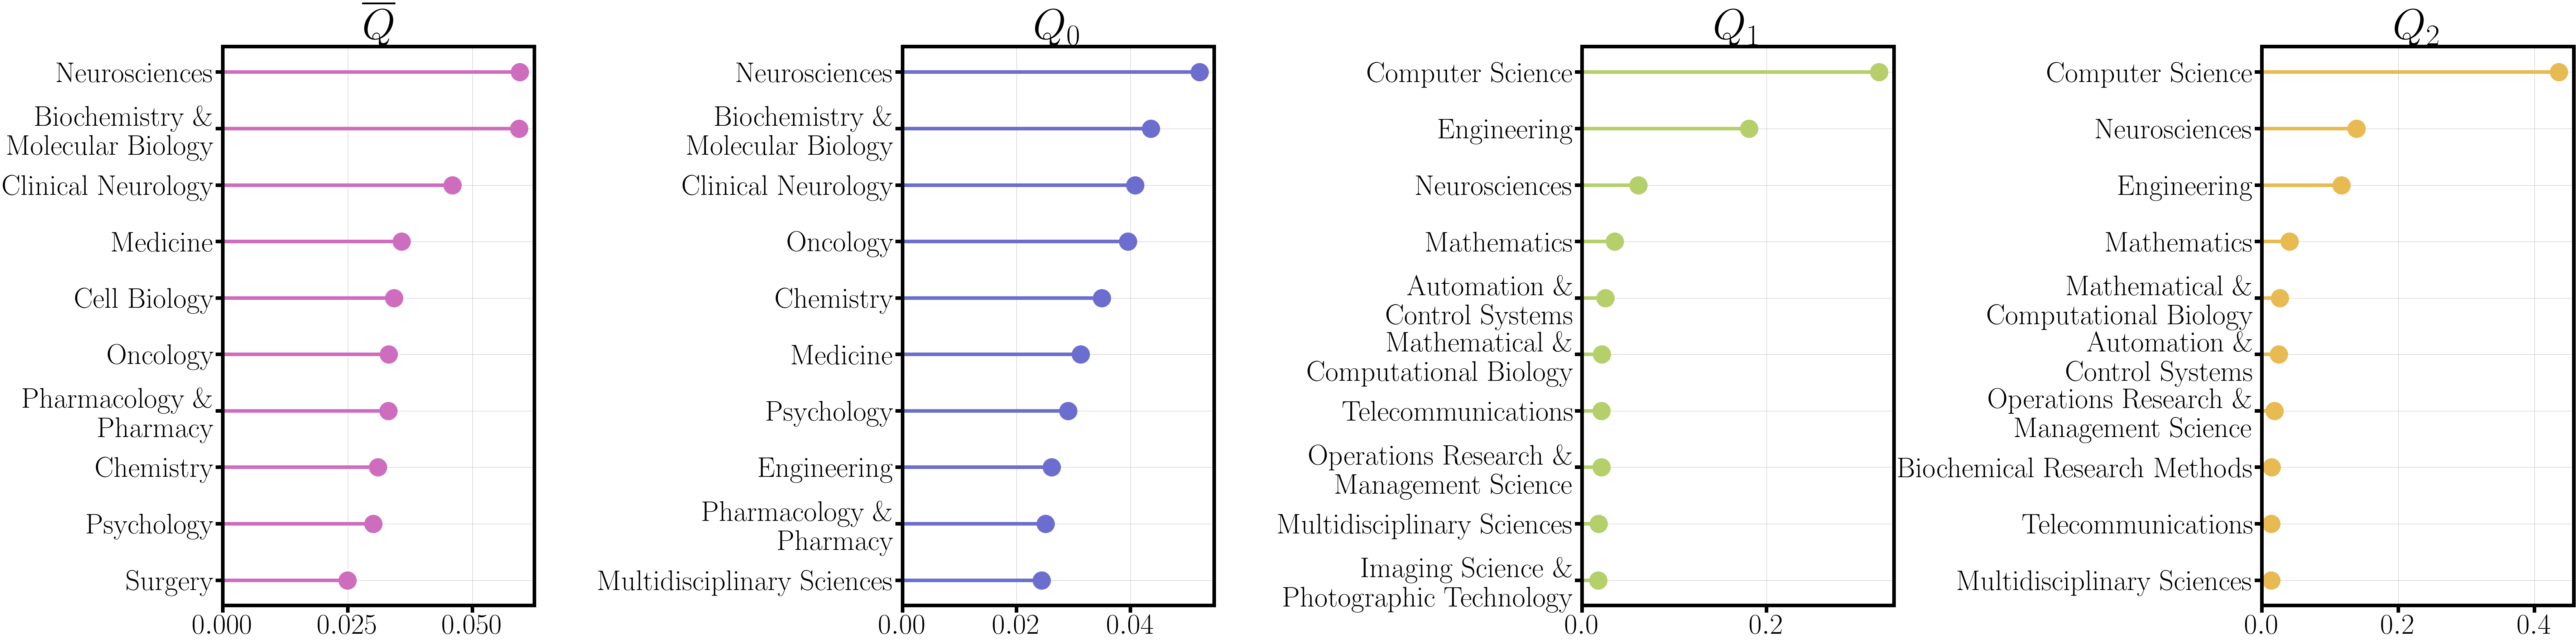

In [600]:
# for disciplines
fig, axs = plt.subplots(1, len(disciplines), figsize=(100,25))
n = 10
plt.rc('axes', linewidth=n)
ticksSizeMajor = 20
ticksSizeMinor = 5
ticksWidth = n
sizeTitle = 120
size_ticksLabel=80
size_axisLabel=120
cmap = plt.cm.tab20b.colors
colors = [cmap[18], cmap[2], cmap[6], cmap[10], cmap[14]]
top = 10

for j in range(len(disciplines)):
    x = np.array(list(disciplines[j].values())[-top:])/sum(disciplines[j].values()) #histo == disciplines
    y = [i for i in range(top)]
    axs[j].hlines(y, 0, x, color=colors[j], linewidth=10)
    axs[j].plot(x, y, 'o', color=colors[j], ms=50)
    ticks = []
    for d in list(disciplines[j].keys())[-top:]:
        if '&' in d:
            ticks.append(d.replace('&', '\&\n').title())
        elif len(d.split())>3:
            ticks.append(''.join([f'\n{j}' for j in d.split()[::3]]).title())
        else:
            ticks.append(d.title())
    axs[j].set_yticks(y, ticks) 
    axs[j].set_xlim(left=0)
    #axs[j].set_ylim(bottom=0)
    if j == 0:
        axs[j].set_title(r'$\overline{Q}$', fontsize=sizeTitle)
    else:    
        axs[j].set_title(f'$Q_{j-1}$', fontsize=sizeTitle)
    axs[j].tick_params(labelsize=size_ticksLabel, length=ticksSizeMajor, width=ticksWidth)
    axs[j].grid()
plt.tight_layout()
filename = r'main_disciplines_authors_per_quartile.pdf'
#plt.savefig(f'{path_output}/{filename}', format='pdf', bbox_inches='tight')

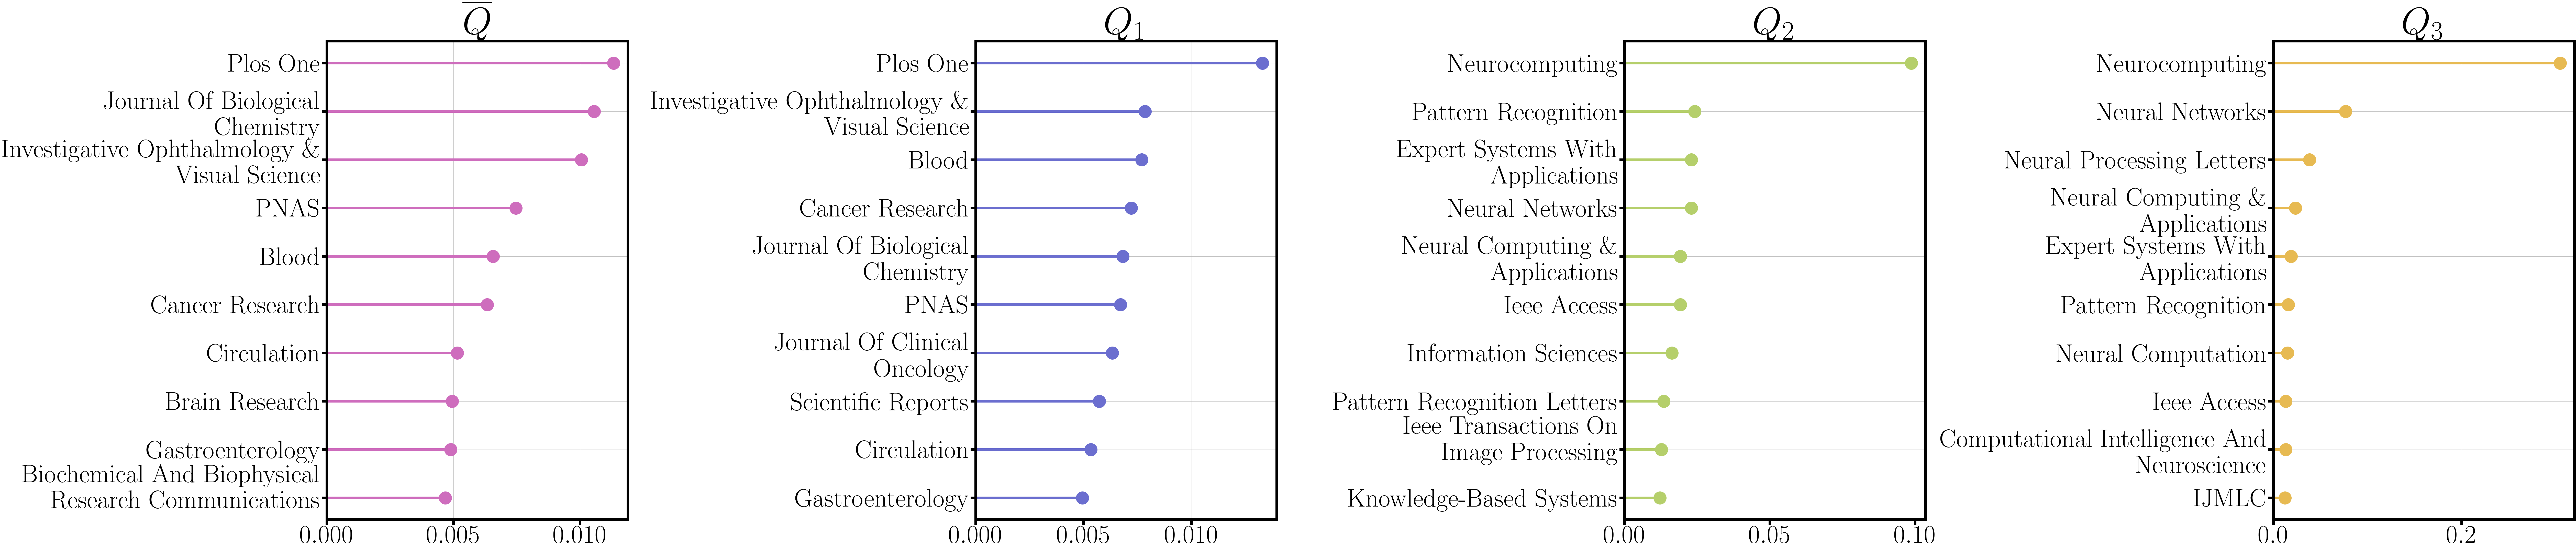

In [609]:
### for journals
fig, axs = plt.subplots(1, len(journals), figsize=(140,30))
n = 10
plt.rc('axes', linewidth=n)
ticksSizeMajor = 20
ticksSizeMinor = 5
ticksWidth = n
sizeTitle = 150
size_ticksLabel=100
size_axisLabel=120
cmap = plt.cm.tab20b.colors
colors = [cmap[18], cmap[2], cmap[6], cmap[10], cmap[14]]
top = 10

for j in range(len(journals)):
    x = np.array(list(journals[j].values())[-top:])/sum(journals[j].values()) #histo == disciplines
    y = [i for i in range(top)]
    axs[j].hlines(y, 0, x, color=colors[j], linewidth=10)
    axs[j].plot(x, y, 'o', color=colors[j], ms=50)
    ticks = []
    for jo in list(journals[j].keys())[-top:]:
        if '&' in jo:
            ticks.append(jo.replace('&', '\&\n').title())
        elif len(jo.split())>3:
            if jo == 'IEEE TRANSACTIONS ON CIRCUITS AND SYSTEMS II-EXPRESS BRIEFS':
                ticks.append('IEEE TCS II')
            elif jo == 'PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA':
                ticks.append('PNAS')
            elif jo == 'INTERNATIONAL JOURNAL OF MACHINE LEARNING AND CYBERNETICS':
                ticks.append('IJMLC')
            else:
                jo = jo.split()
                ticks.append(' '.join([f'{j}\n' if (jo.index(j)%2==0) & (jo.index(j)!=0) else j for j in jo]).title())
        else:
            ticks.append(jo.title())
    axs[j].set_yticks(y,ticks) 
    axs[j].set_xlim(left=0)
    #axs[j].set_ylim(bottom=0)
    if j == 0:
        axs[j].set_title(r'$\overline{Q}$', fontsize=sizeTitle)
    else:    
        axs[j].set_title(f'$Q_{j}$', fontsize=sizeTitle)
    axs[j].tick_params(labelsize=size_ticksLabel, length=ticksSizeMajor, width=ticksWidth)
    axs[j].grid()
plt.tight_layout()
filename = r'main_journals_authors_per_quartile.pdf'
#plt.savefig(f'{path_output}/{filename}', format='pdf', bbox_inches='tight')

# 4 - Study the share of wheigted edges between each quartile

In [27]:
def quantile_edge_matrix(quantile,df_authors,df_collab):    
    # total number of weighted edges
    matrix = np.zeros((len(quantile),len(quantile)))
    # select first the authors in each quantile that have AI_score > 0
    for i in range(len(quantile)):
        if i != 3:
            ego_authors = df_authors[(df_authors['AIscore_all']>=quantile[i]) 
                                     & (df_authors['AIscore_all']<quantile[i+1])]['authorId']
        else:
            ego_authors = df_authors[df_authors['AIscore_all']>=quantile[i]]['authorId']
        subnet = df_collab[df_collab['author1'].isin(ego_authors)|
                           df_collab['author2'].isin(ego_authors)]
        # search the colleagues in each quantile, those having AI_score == 0 are included in quantile the first quantile over 5
        for j in range(i,len(quantile)):
            #print(i,j)
            if i != j:
                if j != 3:
                    other_authors = df_authors[(df_authors['AIscore_all']>=quantile[j]) 
                                               & (df_authors['AIscore_all']<quantile[j+1])]['authorId']
                else:
                    other_authors = df_authors[df_authors['AIscore_all']>=quantile[j]]['authorId']
                # keep the egocentric network around ego_authors and keep only colleagues within the current quartile

                subsubnet = subnet[subnet['author1'].isin(other_authors)|
                                   subnet['author2'].isin(other_authors)]
            else:
                subsubnet = df_collab[df_collab['author1'].isin(ego_authors)&
                                       df_collab['author2'].isin(ego_authors)]
            nb_edges = sum(subsubnet['w']) # here the weights
            matrix[i][j] = nb_edges
            if i!=j:
                matrix[j][i] = nb_edges
    return matrix

In [33]:
matrix_obs = quantile_edge_matrix(quantile,authorsInPapers_sub,sub_collabNet_timeagg)

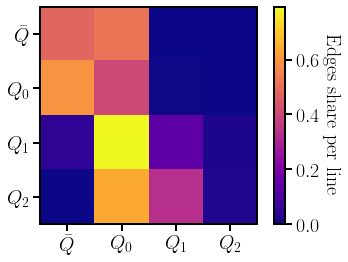

In [614]:
# normalisation of the matrix per line in order to have the share in each quartile
matrix_norm = matrix_obs/np.sum(matrix_obs, axis=0)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
im = ax.imshow(matrix_norm.transpose(), cmap='plasma')
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
ax.set_xticks(np.arange(len(matrix_norm)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(matrix_norm)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"Edges share per line", rotation=-90, va='bottom', fontsize=20)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4.1 - Evolution of the share of edges between $\overline{Q}$ and all other $Q$s

In [244]:
edges_qbar_qs = []
for y in tqdm(set(sub_collabNet['year'])):
    cn = sub_collabNet[sub_collabNet['year']==y][['author1','author2','w']]
    cn = pd.merge(cn.rename(columns={'author1':'authorId'}), 
                  authorsInPapers_sub[['authorId','quartile']],
                  on='authorId',
                  how='left').rename(columns={'quartile':'q1'})[['author2','w','q1']]
    cn = pd.merge(cn.rename(columns={'author2':'authorId'}), 
                  authorsInPapers_sub[['authorId','quartile']],
                  on='authorId',
                  how='left').rename(columns={'quartile':'q2'})
    cn = cn[['q1','q2','w']].groupby(['q1','q2']).sum().reset_index()
    nb_edges_tot = cn['w'].sum()
    nb_edges_qbar_qs = cn[((cn['q1']==-1)&(cn['q2']!=-1))|((cn['q1']!=-1)&(cn['q2']==-1))]['w'].sum()
    edges_qbar_qs.append(nb_edges_qbar_qs/nb_edges_tot)

100%|███████████████████████████████████████████| 51/51 [00:09<00:00,  5.32it/s]


<Figure size 432x288 with 0 Axes>

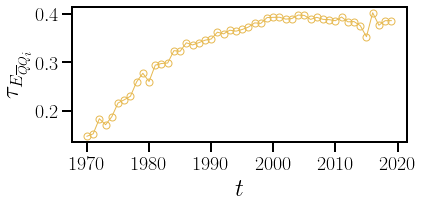

In [245]:
cmap1 = plt.cm.tab20b.colors
plt.clf()
fig = plt.figure(figsize=(6, 2.5))
axins = plt.axes()
axins.plot(np.arange(1970, 2020), edges_qbar_qs[:-1], marker='o', mfc='none', linewidth=1, color=cmap1[10], markersize=7)
axins.set_ylabel(r'$\tau_{E_{\overline{Q}Q_i}}$', fontsize=axisLabelSize)
axins.set_xlabel(r'$t$', fontsize=axisLabelSize)
#axins.set_ylim(0.05,0.25)
axins.set_xticks([i for i in range(1970, 2021, 10)])
axins.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
#plt.savefig(f'{path_output}nbauthors_perscore_ratio.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4.2 - Evolution of the rate of number of edges per quartile

In [637]:
groups = ['Qbar','Q0','Q1','Q2']
edges_quantile = {k:{k:[] for k in groups} for k in groups}
for i in range(len(quantile)):
    if i != 3:
        ego_authors = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>=quantile[i]) 
                                          & (authorsInPapers_sub['AIscore_all']<quantile[i+1])]['authorId']
    else:
        ego_authors = authorsInPapers_sub[authorsInPapers_sub['AIscore_all']==quantile[i]]['authorId']
    for y in tqdm(set(allpapers['publicationYear'])):
        sub_collabNet_y = sub_collabNet[sub_collabNet['year']==y]
        colleagues = set(sub_collabNet_y[sub_collabNet_y['author1'].isin(ego_authors)]['author2']) | set(sub_collabNet_y[sub_collabNet_y['author2'].isin(ego_authors)]['author1'])
        for j in range(i,len(quantile)):
            if j != 3:
                colleagues_quantile = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>=quantile[j]) 
                                           &  (authorsInPapers_sub['AIscore_all']<quantile[j+1])
                                           & (authorsInPapers_sub['authorId'].isin(colleagues))]['authorId']
            else:
                colleagues_quantile = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']==quantile[j]) 
                                           & (authorsInPapers_sub['authorId'].isin(colleagues))]['authorId']
            # here the weights
            nb_edges = sum(sub_collabNet_y[(sub_collabNet_y['author1'].isin(ego_authors))|(sub_collabNet_y['author2'].isin(ego_authors))
                                        &(sub_collabNet_y['author1'].isin(colleagues_quantile))|(sub_collabNet_y['author2'].isin(colleagues_quantile))]['w'])
            edges_quantile[groups[i]][groups[j]].append(nb_edges)
            if i != j:
                edges_quantile[groups[j]][groups[i]].append(nb_edges)

100%|███████████████████████████████████████████| 51/51 [00:01<00:00, 34.51it/s]


In [638]:
# normalization per line
edges_quantile_normalized = {k:{k:[] for k in groups} for k in groups}
for k in edges_quantile.keys():
    total_edges_quantile = np.sum(np.array(list(edges_quantile[k].values())), axis=0)
    edges_quantile_normalized[k] = {l:np.array(edges_quantile[k][l])/total_edges_quantile for l in edges_quantile[k].keys()}

In [642]:
edges_quantile = []
for y in tqdm(set(sub_collabNet['year'])):
    sub_collabNet_y = sub_collabNet[sub_collabNet['year']==y][['author1','author2','w']]
    edges_quantile.append(quantile_edge_matrix(quantile,authorsInPapers_sub,sub_collabNet_y))

100%|███████████████████████████████████████████| 51/51 [00:12<00:00,  4.15it/s]


In [647]:
edges_quantile = np.transpose(edges_quantile)

In [664]:
for i in range(len(edges_quantile)):
    edges_quantile[i] = edges_quantile[i]/np.sum(edges_quantile[i],axis=0)

/tmp/ipykernel_119233/3395502106.py:2: RuntimeWarning: invalid value encountered in divide
  edges_quantile[i] = edges_quantile[i]/np.sum(edges_quantile[i],axis=0)


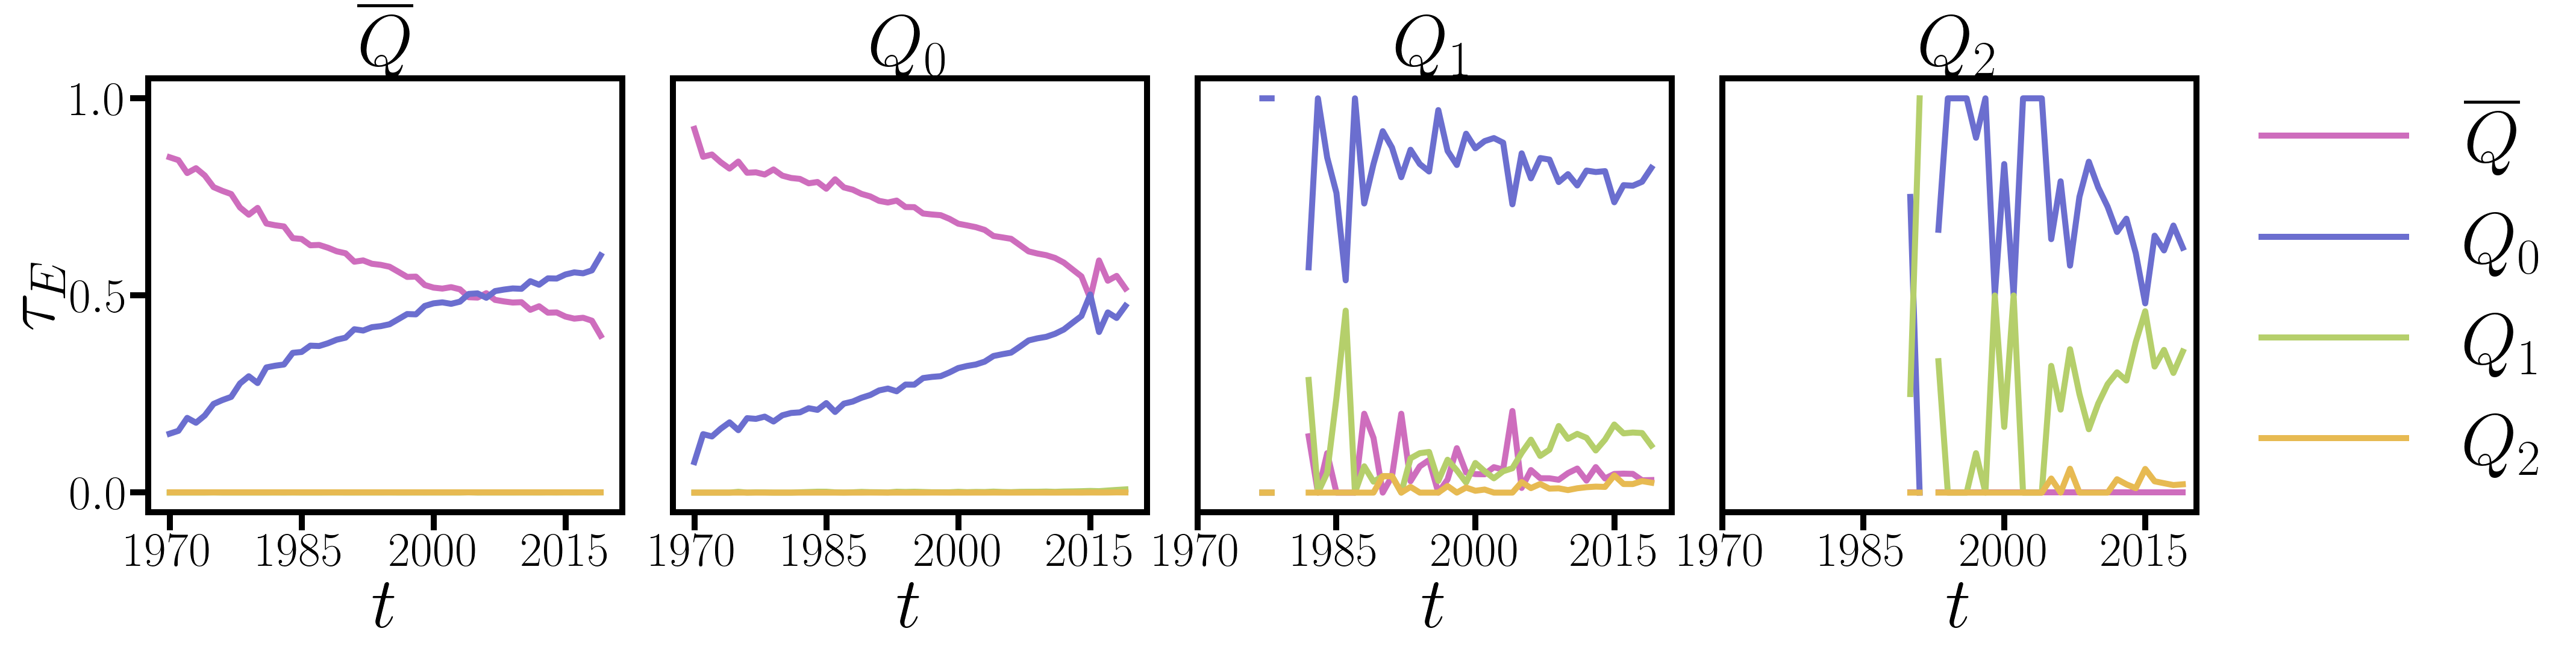

In [671]:
fig, axs = plt.subplots(1, len(edges_quantile), figsize=(60,15))
n = 10
plt.rc('axes', linewidth=n)
ticksSizeMajor = 30
ticksSizeMinor = 5
ticksWidth = n
sizeTitle = 120
size_ticksLabel=80
size_axisLabel=120
cmap = plt.cm.tab20b.colors
colors = [cmap[18], cmap[2], cmap[6], cmap[10], cmap[14]]
#colors = [cmap[0], cmap[2], cmap[4], cmap[6], cmap[8]]
labels = [r'$\overline{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$']
for i in range(len(edges_quantile)):
    for j in range(len(edges_quantile)):
        axs[i].plot(np.arange(1970,2020,1), edges_quantile[i][j][:-1], 
                    'o-', 
                    color=colors[j],
                    linewidth=10,
                    ms=0,
                    mfc='none')
    axs[i].set_ylim(bottom=-0.05, top=1.05)
    axs[i].set_xticks(np.arange(1970,2021,15))
    axs[i].set_title(labels[i], fontsize=size_axisLabel)
    axs[i].set_xlabel(r'$t$', fontsize=size_axisLabel)
    axs[i].tick_params(labelsize=size_ticksLabel, length=ticksSizeMajor, width=ticksWidth)
    if i == 0:
        axs[i].set_ylabel(r'$\tau_E$', fontsize=size_axisLabel)
    else:
        axs[i].set_yticks([])
plt.legend(labels=labels, bbox_to_anchor=(1, 1.1), ncol=1, fontsize=sizeTitle, frameon=False)
plt.tight_layout()
filename = r'temporal_edges_between_quartile.pdf'
#plt.savefig(f'{path_output}/{filename}', format='pdf', bbox_inches='tight')

# 5 - Study of the $z$-score matrix indicating the propensity of quartiles linking
The rewiring of the empirical collaboration network below conserves the degree distribution.

In [25]:
sub_collabNet_timeagg_copy = []
for i in tqdm(sub_collabNet_timeagg.index):
    sub_collabNet_timeagg_copy += [(sub_collabNet_timeagg.loc[i,'author1'],sub_collabNet_timeagg.loc[i,'author2'])]*sub_collabNet_timeagg.loc[i,'w']
sub_collabNet_timeagg_copy = pd.DataFrame(sub_collabNet_timeagg_copy,columns=['author1','author2'])
sub_collabNet_timeagg_copy

100%|██████████████████████████████| 7420423/7420423 [02:49<00:00, 43713.98it/s]


,author1,author2
0,2657500882,2674014771
1,2657500882,2674014771
2,2685564105,2697218247
3,2498309307,2583882005
4,2161601479,2665692746
...,...,...
10785911,2795445455,2974030712
10785912,2795445455,2973596606
10785913,2973232662,2974030712
10785914,2973232662,2973596606


In [150]:
# shuffle avoiding selfloops but keeping parallel edges (this is the frequency of a collaboration)
# --> this function keeps the degree distribution
# control if all the simu are different?
# need a developed collabNet as input (expand with the 'w' column) to avoid to redo the transformation N times
def shuffle(collab,source,target):
    net = collab.copy(deep=True)
    np.random.shuffle(net[target].values)
    selfloops = net[net[source]==net[target]]
    #print(selfloops)
    if not selfloops.empty:
        for i in selfloops[source]:
            for ind_toreplace in selfloops[selfloops[source]==i].index:
                newind = random.choice(net[net[target] != i].index)
                ide = net.loc[newind, target]
                net.loc[newind, target] = net.loc[ind_toreplace, target]
                net.loc[ind_toreplace, target] = ide
    net['w'] = 1
    net = net.groupby(['author1','author2']).sum('w').reset_index()
    return net

In [29]:
# compute the z-score
N = 100
simu_matrix = []
for n in tqdm(range(N)):
    simu_matrix.append(quantile_edge_matrix(quantile,authorsInPapers_sub,shuffle(sub_collabNet_timeagg_copy,'author1','author2')))

100%|█████████████████████████████████████████| 100/100 [40:58<00:00, 24.59s/it]


In [34]:
mean_simu = np.mean(simu_matrix,axis=0)
std_simu = np.std(simu_matrix,axis=0,ddof=0)
z = (matrix_obs-mean_simu)/std_simu
z[np.isnan(z)] = 0 # nan: result of mean_simu=observed_data, and the simus give exactly the same values
z[np.isinf(z)] = (matrix_obs-mean_simu)[np.where(np.isinf(z))] # inf: same values of the simulations, but not coinciding with the data

In [35]:
z = z/np.max(abs(z))

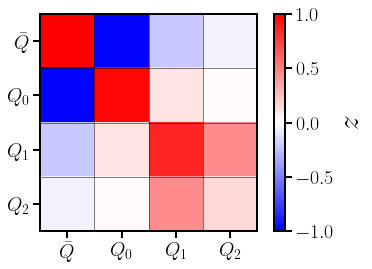

In [36]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
divnorm = colors.TwoSlopeNorm(vmin=-np.max(abs(z)), vcenter=0, vmax=np.max(abs(z)))
im = ax.imshow(z, cmap='bwr', norm=divnorm)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth);
ax.hlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.vlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.set_xticks(np.arange(len(z)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(z)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$z$", rotation=-90, va='bottom', fontsize=30)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 5.1 - Temporal evolution of the $z$-score for each quartile with no cumulative process (only snapshots)

In [38]:
N = 100
z_temporal = []
for y in tqdm(set(sub_collabNet['year'])):
    sub_collabNet_y = sub_collabNet[sub_collabNet['year']==y][['author1','author2','w']]
    matrix_obs = quantile_edge_matrix(quantile,authorsInPapers_sub,sub_collabNet_y)
    sub_collabNet_y_copy = []
    for i,j,w in sub_collabNet_y.values:
        sub_collabNet_y_copy += [(i,j)]*w
    sub_collabNet_y_copy = pd.DataFrame(sub_collabNet_y_copy,columns=['author1','author2'])
    simu_matrix = []
    for i in range(N):
        simu_matrix.append(quantile_edge_matrix(quantile,authorsInPapers_sub,shuffle(sub_collabNet_y_copy,'author1','author2')))
    mean_simu = np.mean(simu_matrix,axis=0)
    std_simu = np.std(simu_matrix,axis=0,ddof=0)
    z = (matrix_obs-mean_simu)/std_simu
    # replace nan and inf values by other values
    z[np.isnan(z)] = 0 # nan: result of mean_simu=observed_data, and the simus give exactly the same values
    z[np.isinf(z)] = (matrix_obs-mean_simu)[np.where(np.isinf(z))] # inf: same values of the simulations, but not coinciding with the data
    z_temporal.append(z)

  0%|                                                    | 0/51 [00:00<?, ?it/s]/tmp/ipykernel_137965/3032084679.py:15: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu
  2%|▊                                           | 1/51 [00:13<11:25, 13.72s/it]/tmp/ipykernel_137965/3032084679.py:15: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu
  4%|█▋                                          | 2/51 [00:27<11:15, 13.79s/it]/tmp/ipykernel_137965/3032084679.py:15: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu
  6%|██▌                                         | 3/51 [00:40<10:47, 13.49s/it]/tmp/ipykernel_137965/3032084679.py:15: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu
  8%|███▍                                        | 4/51 [00:53<10:29, 13.40s/it]/tmp/ipykernel_137965/3032084679.py:15: RuntimeWarning: invalid value encountere

In [39]:
z_temporal_norm = np.transpose([z/np.max(abs(z)) for z in z_temporal])

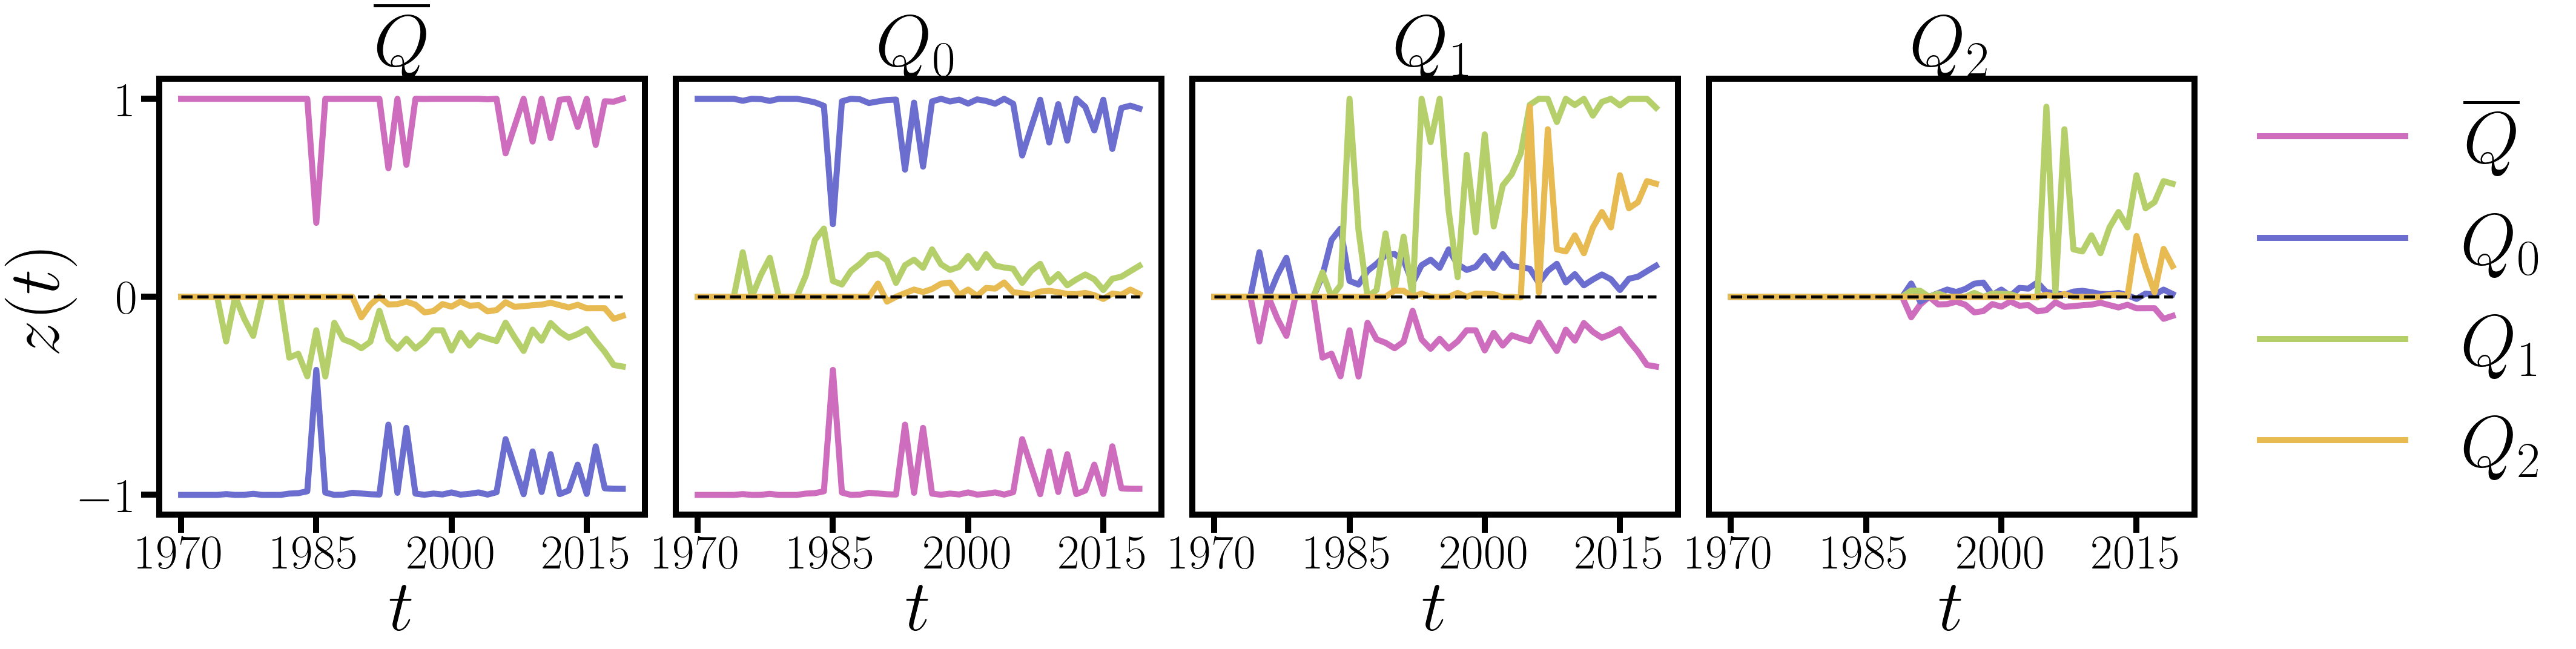

In [42]:
fig, axs = plt.subplots(1, len(z_temporal_norm), figsize=(60,15))
n = 10
plt.rc('axes', linewidth=n)
ticksSizeMajor = 30
ticksSizeMinor = 5
ticksWidth = n
sizeTitle = 120
size_ticksLabel=80
size_axisLabel=120
cmap = plt.cm.tab20b.colors
colors = [cmap[18], cmap[2], cmap[6], cmap[10], cmap[14]]
#colors = [cmap[0], cmap[2], cmap[4], cmap[6], cmap[8]]
labels = [r'$\overline{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$']
for i in range(len(z_temporal_norm)):
    for j in range(len(z_temporal_norm)):
        axs[i].plot(np.arange(1970,2020,1),z_temporal_norm[i][j][:-1], 
                    'o-', 
                    color=colors[j],
                    linewidth=10,
                    ms=0,
                    mfc='none')
    axs[i].plot(np.arange(1970,2020,1), [0]*50, '--', color='black', linewidth=5)
    axs[i].set_ylim(bottom=-1.1, top=1.1)
    axs[i].set_xticks(np.arange(1970,2021,15))
    axs[i].set_title(labels[i], fontsize=size_axisLabel)
    axs[i].set_xlabel(r'$t$', fontsize=size_axisLabel)
    axs[i].tick_params(labelsize=size_ticksLabel, length=ticksSizeMajor, width=ticksWidth)
    if i == 0:
        axs[i].set_ylabel(r'$z(t)$', fontsize=size_axisLabel)
    else:
        axs[i].set_yticks([])
plt.legend(labels=labels, bbox_to_anchor=(1, 1.1), ncol=1, fontsize=sizeTitle, frameon=False)
plt.tight_layout()
filename = r'temporal_edges_between_quartile.pdf'
#plt.savefig(f'{path_output}/{filename}', format='pdf', bbox_inches='tight')

## 5.2 - Split the previous study in different time periods

Periods based on the begining of the significance of a class in its distribution of the begining of scientists' careers:
- 1970-1990: $Q_0$ reign
- 1991-2000: apparition and growth of $Q_1$ class
- 2001-2010: apparition and growth of $Q_2$ class
- 2011-2019: how are drawn the links between these three communities? --> there is a concentration links in the last periods

In [147]:
# expand a condensed list of edges with weight by copying the multiple edges
def to_edge_list_expanding_weight(sub_collabNet_timeagg):
    sub_collabNet_timeagg_copy = []
    for i in tqdm(sub_collabNet_timeagg.index):
        sub_collabNet_timeagg_copy += [(sub_collabNet_timeagg.loc[i,'author1'],sub_collabNet_timeagg.loc[i,'author2'])]*sub_collabNet_timeagg.loc[i,'w']
    sub_collabNet_timeagg_copy = pd.DataFrame(sub_collabNet_timeagg_copy,columns=['author1','author2'])
    return sub_collabNet_timeagg_copy

In [148]:
# add weights
def aggregate(temporal_collab_network):
    cn = {}
    for i,j,w in tqdm(temporal_collab_network[['author1','author2','w']].values):
        if (i,j) in cn:
            cn[(i,j)] += w
        elif (j,i) in cn:
            cn[(j,i)] += w
        else:
            cn[(i,j)] = w
    cn = pd.DataFrame.from_records([(i,j,k) for ((i,j),k) in cn.items()], columns=['author1','author2','w'])
    return cn

In [145]:
def z_matrix_edgesBetweenQuartiles_period(by, ey, authors_years_wos, authorsInPapers_sub, collabNet, quantile, N_simu=100):
    # ---------- select subdatasets for this period ----------
    a = set(authors_years_wos[(authors_years_wos['publicationYear']>=by) & (authors_years_wos['publicationYear']<ey)]['authorId'])
    authors_period = authorsInPapers_sub[authorsInPapers_sub['authorId'].isin(a)]
    collabNet_timeaggregated = aggregate(collabNet[(collabNet['year']>=by) & (collabNet['year']<ey)])
    # ---------- Compute edge matrix ----------
    matrix_obs = quantile_edge_matrix(quantile,authors_period,collabNet_timeaggregated)
    # ---------- Compute an weight-expanded copy of the edges list ----------
    collabNet_timeaggregated_copy = to_edge_list_expanding_weight(collabNet_timeaggregated)
    # ---------- Compute the normalized z-score with the different network shufflings ----------
    simus_matrix = []
    for n in tqdm(range(N_simu)):
        simus_matrix.append(quantile_edge_matrix(quantile,authors_period,shuffle(collabNet_timeaggregated_copy,'author1','author2')))
    mean_simu = np.mean(simus_matrix,axis=0)
    std_simu = np.std(simus_matrix,axis=0,ddof=0)
    z = (matrix_obs-mean_simu)/std_simu
    z[np.isnan(z)] = 0 # nan: result of mean_simu=observed_data, and the simus give exactly the same values
    z[np.isinf(z)] = (matrix_obs-mean_simu)[np.where(np.isinf(z))] # inf: same values of the simulations, but not coinciding with the data
    return z/np.max(abs(z))

### 5.2.1 - $1970-1979$

In [151]:
z = z_matrix_edgesBetweenQuartiles_period(1970, 1980, authors_years_wos, authorsInPapers_sub, collabNet, quantile)

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]
/tmp/ipykernel_82350/3706616991.py:16: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu


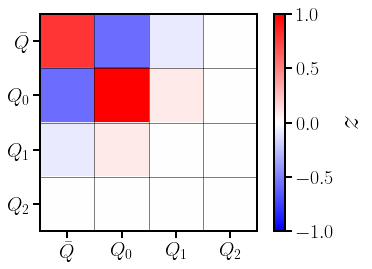

In [152]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
#divnorm = colors.TwoSlopeNorm(vmin=-np.max(abs(z)), vcenter=0, vmax=np.max(abs(z)))
im = ax.imshow(z, cmap='bwr', norm=divnorm)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth);
ax.hlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.vlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.set_xticks(np.arange(len(z)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(z)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$z$", rotation=-90, va='bottom', fontsize=30)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [217]:
wos_domains = []
authors_period = set(authors_years_wos[(authors_years_wos['publicationYear']>=1970) & (authors_years_wos['publicationYear']<1980)]['authorId'])
for q in [0]:
    print(q)
    authors_q = authorsInPapers_sub[(authorsInPapers_sub['quartile']==q) & (authorsInPapers_sub['authorId'].isin(authors_period))]['authorId']
    wos_domains.append(Counter([w.replace("'",'').replace('[','').replace(']','') 
                                for w in map(str,authors_careers_sub[authors_careers_sub['authorId'].isin(authors_q)]['wos_begin'].explode('wos_begin')) 
                                if w!='-1']))
# sort the counters
for i in range(len(wos_domains)):
    wos_domains[i] = {k:wos_domains[i][k] for k in sorted(wos_domains[i], key=wos_domains[i].get)}

0


TypeError: 'AxesSubplot' object is not subscriptable

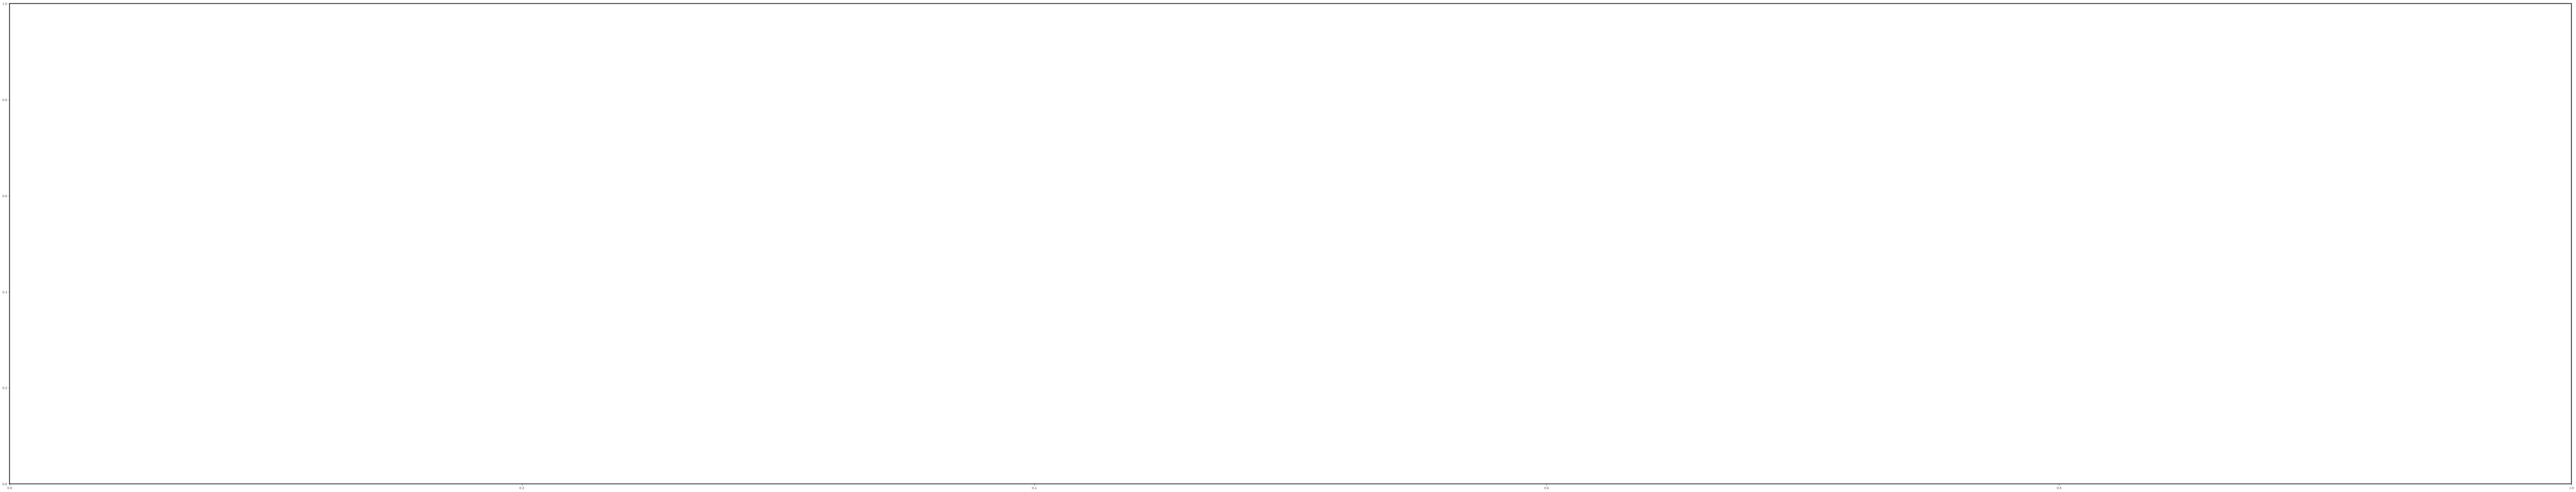

In [219]:
fig, axs = plt.subplots(1, len(wos_domains), figsize=(130,25))
n = 10
plt.rc('axes', linewidth=n)
ticksSizeMajor = 20
ticksSizeMinor = 5
ticksWidth = n
sizeTitle = 120
size_ticksLabel=80
size_axisLabel=120
cmap = plt.cm.tab20b.colors
colors = [cmap[18], cmap[2], cmap[6], cmap[10], cmap[14]]
top = 10

for j in range(len(wos_domains)):
    x = np.array(list(wos_domains[j].values())[-top:])/sum(wos_domains[j].values()) #histo == disciplines
    y = [i for i in range(top)]
    axs[j].hlines(y, 0, x, color=colors[j], linewidth=10)
    axs[j].plot(x, y, 'o', color=colors[j], ms=50)
    ticks = []
    for d in list(wos_domains[j].keys())[-top:]:
        if '&' in d:
            ticks.append(d.replace('&', '\&\n').title())
        elif len(d.split())>3:
            ticks.append(''.join([f'\n{j}' for j in d.split()[::3]]).title())
        else:
            ticks.append(d.title())
    axs[j].set_yticks(y, ticks) 
    axs[j].set_xlim(left=0)
    #axs[j].set_ylim(bottom=0)
    axs[j].set_title(f'$Q_{j}$', fontsize=sizeTitle)
    axs[j].tick_params(labelsize=size_ticksLabel, length=ticksSizeMajor, width=ticksWidth)
    axs[j].grid()
plt.tight_layout()
filename = r'main_disciplines_authors_per_quartile.pdf'
#plt.savefig(f'{path_output}/{filename}', format='pdf', bbox_inches='tight')

### 5.2.2 - $1980-1987$

In [156]:
z = z_matrix_edgesBetweenQuartiles_period(1980, 1988, authors_years_wos, authorsInPapers_sub, collabNet, quantile)

100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]
/tmp/ipykernel_82350/3706616991.py:16: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu


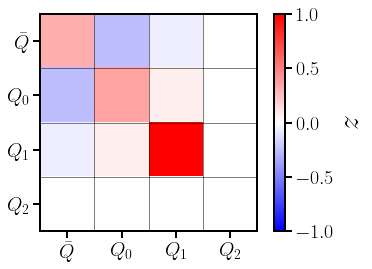

In [157]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
#divnorm = colors.TwoSlopeNorm(vmin=-np.max(abs(z)), vcenter=0, vmax=np.max(abs(z)))
im = ax.imshow(z, cmap='bwr', norm=divnorm)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth);
ax.hlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.vlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.set_xticks(np.arange(len(z)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(z)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$z$", rotation=-90, va='bottom', fontsize=30)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 5.2.3 - $1988-1997$

In [158]:
z = z_matrix_edgesBetweenQuartiles_period(1988, 1998, authors_years_wos, authorsInPapers_sub, collabNet, quantile)

100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]
/tmp/ipykernel_82350/3706616991.py:16: RuntimeWarning: divide by zero encountered in divide
  z = (matrix_obs-mean_simu)/std_simu
/tmp/ipykernel_82350/3706616991.py:16: RuntimeWarning: invalid value encountered in divide
  z = (matrix_obs-mean_simu)/std_simu


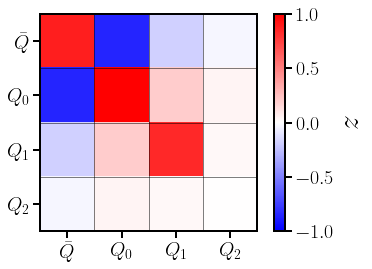

In [159]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
#divnorm = colors.TwoSlopeNorm(vmin=-np.max(abs(z)), vcenter=0, vmax=np.max(abs(z)))
im = ax.imshow(z, cmap='bwr', norm=divnorm)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth);
ax.hlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.vlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.set_xticks(np.arange(len(z)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(z)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$z$", rotation=-90, va='bottom', fontsize=30)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 5.2.4 -  $1998-2010$

In [160]:
z = z_matrix_edgesBetweenQuartiles_period(1998, 2011, authors_years_wos, authorsInPapers_sub, collabNet, quantile)

100%|█████████████████████████████████████████| 100/100 [15:25<00:00,  9.25s/it]


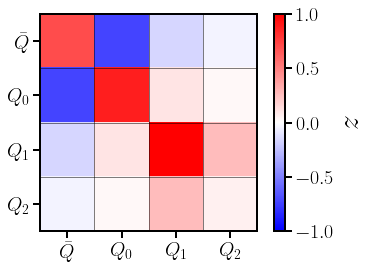

In [161]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
#divnorm = colors.TwoSlopeNorm(vmin=-np.max(abs(z)), vcenter=0, vmax=np.max(abs(z)))
im = ax.imshow(z, cmap='bwr', norm=divnorm)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth);
ax.hlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.vlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.set_xticks(np.arange(len(z)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(z)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$z$", rotation=-90, va='bottom', fontsize=30)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 5.2.5 - $2011-2019$

In [162]:
z = z_matrix_edgesBetweenQuartiles_period(2011, 2020, authors_years_wos, authorsInPapers_sub, collabNet, quantile)

100%|█████████████████████████████████████████| 100/100 [38:33<00:00, 23.14s/it]


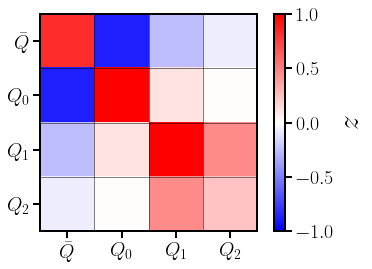

In [163]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
#divnorm = colors.TwoSlopeNorm(vmin=-np.max(abs(z)), vcenter=0, vmax=np.max(abs(z)))
im = ax.imshow(z, cmap='bwr', norm=divnorm)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth);
ax.hlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.vlines(np.arange(-0.5,len(z)), -0.5, len(z)-0.5, color='black', linestyles='solid', linewidths=0.5)
ax.set_xticks(np.arange(len(z)),[r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
ax.set_yticks(np.arange(len(z)), [r'$\bar{Q}$',r'$Q_0$',r'$Q_1$',r'$Q_2$'])
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$z$", rotation=-90, va='bottom', fontsize=30)
cbar.ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor-3, width=ticksWidth)
#cbar.ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=20)
#plt.savefig(f'{path_output}edges_between_quartile.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [256]:
collabNet

,author1,author2,year,w_AI,w_nonAI,w
0,62087602,2711936818,1970,1,0,1
1,2723263018,2471576797,1970,1,0,1
2,2723263018,2763368074,1970,1,0,1
3,2471576797,2763368074,1970,1,0,1
4,2721961912,2489946790,1970,1,0,1
...,...,...,...,...,...,...
12637310,2974030712,2995845628,2020,0,1,1
12637311,2974030712,2973596606,2020,0,1,1
12637312,3011857465,2995845628,2020,0,1,1
12637313,3011857465,2973596606,2020,0,1,1


In [257]:
sum(collabNet['w'])

13786616

In [260]:
print(collabNet[(collabNet['year']>=1970) & (collabNet['year']<=1979)]['w'].sum()/collabNet['w'].sum())
print(collabNet[(collabNet['year']>=1980) & (collabNet['year']<=1987)]['w'].sum()/collabNet['w'].sum())
print(collabNet[(collabNet['year']>=1988) & (collabNet['year']<=1997)]['w'].sum()/collabNet['w'].sum())
print(collabNet[(collabNet['year']>=1998) & (collabNet['year']<=2010)]['w'].sum()/collabNet['w'].sum())
print(collabNet[(collabNet['year']>=2011) & (collabNet['year']<=2019)]['w'].sum()/collabNet['w'].sum())
print(collabNet[(collabNet['year']>=1998) & (collabNet['year']<=2019)]['w'].sum()/collabNet['w'].sum())

0.0061474839075810915
0.01828062811062555
0.06548068068335261
0.36610971104149126
0.5423174185746524
0.9084271296161437


## 5.3 - Temporal evolution of the $z$-score between the AI scientists, ie. $\{Q_0,Q_1,Q_2\}$, and all  the others, ie. $\overline{Q}$

In [257]:
N = 100
z_edges_qbar_qs = []
for y in tqdm(set(sub_collabNet['year'])):
    ########### OBSERVED VALUE #################
    cn = sub_collabNet[sub_collabNet['year']==y][['author1','author2','w']]
    cn_q = pd.merge(cn.rename(columns={'author1':'authorId'}), 
                  authorsInPapers_sub[['authorId','quartile']],
                  on='authorId',
                  how='left').rename(columns={'quartile':'q1'})[['author2','w','q1']]
    cn_q = pd.merge(cn_q.rename(columns={'author2':'authorId'}), 
                  authorsInPapers_sub[['authorId','quartile']],
                  on='authorId',
                  how='left').rename(columns={'quartile':'q2'})
    cn_q = cn_q[['q1','q2','w']].groupby(['q1','q2']).sum().reset_index()
    nb_edges_tot = cn_q['w'].sum()
    nb_edges_qbar_qs = cn_q[((cn_q['q1']==-1)&(cn_q['q2']!=-1))|((cn_q['q1']!=-1)&(cn_q['q2']==-1))]['w'].sum()
    s_obs = nb_edges_qbar_qs/nb_edges_tot
    
    ########### SIMULATED VALUE #################
    cn_copy = []
    for i,j,w in cn.values:
        cn_copy += [(i,j)]*w
    cn_copy = pd.DataFrame(cn_copy,columns=['author1','author2'])
    s_simu = []
    for i in range(N):
        cn_simu = shuffle(cn_copy,'author1','author2')
        cn_simu_q = pd.merge(cn_simu.rename(columns={'author1':'authorId'}), 
                  authorsInPapers_sub[['authorId','quartile']],
                  on='authorId',
                  how='left').rename(columns={'quartile':'q1'})[['author2','w','q1']]
        cn_simu_q = pd.merge(cn_simu_q.rename(columns={'author2':'authorId'}), 
                      authorsInPapers_sub[['authorId','quartile']],
                      on='authorId',
                      how='left').rename(columns={'quartile':'q2'})
        cn_simu_q = cn_simu_q[['q1','q2','w']].groupby(['q1','q2']).sum().reset_index()
        nb_edges_qbar_qs_simu = cn_simu_q[((cn_simu_q['q1']==-1)&(cn_simu_q['q2']!=-1))
                                        |((cn_simu_q['q1']!=-1)&(cn_simu_q['q2']==-1))]['w'].sum()
        s_simu.append(nb_edges_qbar_qs_simu/nb_edges_tot)
    mean_simu = np.mean(s_simu)
    std_simu = np.std(s_simu,ddof=0)
    z_edges_qbar_qs.append((s_obs-mean_simu)/std_simu)

100%|████████████████████████████████████████| 51/51 [2:39:00<00:00, 187.06s/it]


<Figure size 432x288 with 0 Axes>

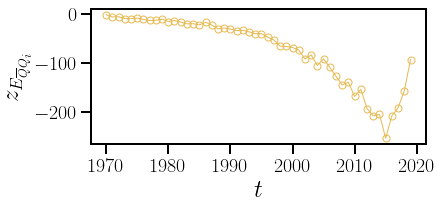

In [276]:
cmap1 = plt.cm.tab20b.colors
plt.clf()
fig = plt.figure(figsize=(6, 2.5))
axins = plt.axes()
axins.plot(np.arange(1970, 2020), z_edges_qbar_qs[:-1], marker='o', mfc='none', linewidth=1, color=cmap1[10], markersize=7)
#axins.plot(np.arange(1970,2020,1), [0]*50, '--', color='red', linewidth=1)
axins.set_ylabel(r'$z_{E_{\overline{Q}Q_i}}$', fontsize=axisLabelSize)
axins.set_xlabel(r'$t$', fontsize=axisLabelSize)
#axins.set_ylim(-275,10)
axins.set_xticks([i for i in range(1970, 2021, 10)])
axins.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
#plt.savefig(f'{path_output}nbauthors_perscore_ratio.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 6 - Evolution of the core disciplines in which authors have been formed within each quartile ("disciplinary background")

Build a list of disciplines per author that is based on the papers published in the first year of publication, whatever the number of papers in this year.

For example, if an author $i$ got in his/her first year of publication 3 publications, here $p_1$ published in a journal with discipline $d_1$, $p_2$ with discpline $d_1$ and $d_2$, and $p_3$ with $d_4$, the disciplinary background of the author $i$ would be the set $\{d_1,d_2,d_4\}$.

In [55]:
authorsInPapers_sub['wos_begin'] = authorsInPapers_sub['wos_begin'].apply(lambda x: eval(x))

/tmp/ipykernel_87417/1776467126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authorsInPapers_sub['wos_begin'] = authorsInPapers_sub['wos_begin'].apply(lambda x: eval(x))


In [19]:
keys = ['$Q_0$','$Q_1$','$Q_2$']
wos_domains = {k:{} for k in keys}
for q in [0,1,2]:
    authors_q = authorsInPapers_sub[authorsInPapers_sub['quartile']==q]
    authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x 
                                                                                          if p!=-1 for d in p]))))
    alldomains = set(authors_q['wos_begin'])-{''}
    wos_domains[keys[q]] = {d:[0] for d in alldomains}
    # homogenize the big categories encountered
    for y in range(1940,2020):
        domains_y = Counter(authors_q[(authors_q['beginYear']==y)&
                                      (authors_q['wos_begin']!=set(''))]['wos_begin'])
        for d in alldomains:
            if d in domains_y:
                wos_domains[keys[q]][d].append(wos_domains[keys[q]][d][-1] + domains_y[d])
            else:
                wos_domains[keys[q]][d].append(wos_domains[keys[q]][d][-1])

/tmp/ipykernel_38655/2933006578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x
/tmp/ipykernel_38655/2933006578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x
/tmp/ipykernel_38655/2933006578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [20]:
# sort the counters taking the values at the end of the period, ie. 2019
wos_domains_count = {k:{l:wos_domains[k][l][-1] for l in wos_domains[k]} for k in keys}
for k in wos_domains_count:
    wos_domains_count[k] = {l:wos_domains_count[k][l] for l in sorted(wos_domains_count[k], key=wos_domains_count[k].get)}

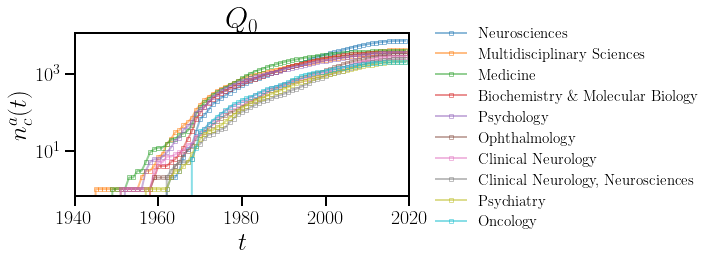

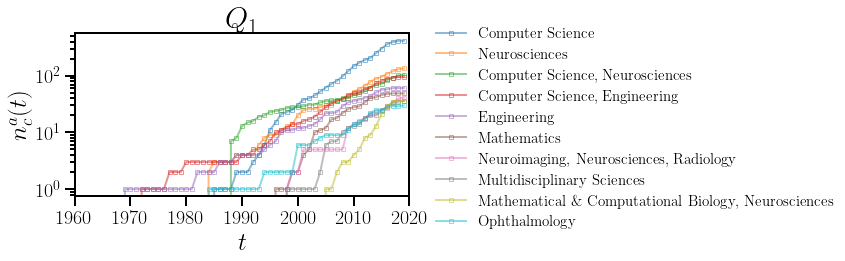

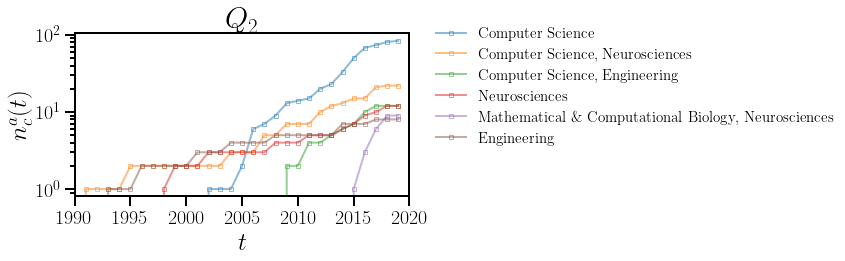

In [61]:
top = 10
l = 0
for k in wos_domains_count:
    fig = plt.figure(figsize=(6, 3))
    axins = plt.axes()
    colors = plt.cm.tab20.colors[::2]
    j = 0
    if k == '$Q_0$':
        by = 1940
        step_xticks = 20
    elif k == '$Q_1$':
        by = 1960
        step_xticks = 10
    elif k == '$Q_2$':
        by = 1990
        step_xticks = 5
    for d in reversed(list(wos_domains_count[k].keys())[-top:]):
        if wos_domains_count[k][d] >= 5:
            '''
            if d in ['Neurosciences','Multidisciplinary Sciences','Computer Science',
                     'Computer Science, Neurosciences', 'Computer Science, Engineering']:
                linesize = 3
                markersize = 5
                alpha = 1
            else:
                linesize = 2
                markersize = 3
                alpha = 0.5
            '''
            linesize = 2
            markersize = 4
            alpha = 0.5
            axins.plot(np.arange(1940,2020), 
                       wos_domains[k][d][1:], 
                       marker='s', mfc='none', linewidth=linesize,
                       color=colors[j], markersize=markersize, alpha=alpha, 
                       label=d.replace('&','\&'))
            j += 1
    axins.set_ylabel(r'$n_c^a(t)$', fontsize=axisLabelSize)
    axins.set_xlabel(r'$t$', fontsize=axisLabelSize)
    axins.set_title(k, fontsize=titleSize)
    #axins.set_ylim(bottom=1)
    axins.set_xlim(left=by,right=2020)
    axins.set_yscale('log')
    axins.set_xticks([i for i in range(by, 2021, step_xticks)])
    axins.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
    axins.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
    axins.legend(bbox_to_anchor=(1.04, 1.12), ncol=1, fontsize=legendSize-5, frameon=False)
    plt.savefig(f'{path_output}cumulnb_authors_disciplines_first_year_Q{l}.pdf', format='pdf', bbox_inches='tight')
    l += 1
    plt.show()

#### Do it also for non-AI scientists in $\overline{Q}$

In [80]:
wos_domains['Qbar'] = {}
authors_q = authorsInPapers_sub[authorsInPapers_sub['quartile']==-1]['authorId']
authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x 
                                                                                        if p!=-1 for d in p]))))
alldomains = set(authors_q['wos_begin'])-{''}
wos_domains['Qbar'] = {d:[0] for d in alldomains}
for y in range(1940,2020):
    domains_y = Counter(authors_q[(authors_q['beginYear']==y)&
                                  (authors_q['wos_begin']!=set(''))]['wos_begin'])
    for d in alldomains:
        if d in domains_y:
            wos_domains['Qbar'][d].append(wos_domains['Qbar'][d][-1] + domains_y[d])
        else:
            wos_domains['Qbar'][d].append(wos_domains['Qbar'][d][-1])
# sort the counters taking the values at the end of the period, ie. 2019
wos_domains_count['Qbar'] = {l:wos_domains['Qbar'][l][-1] for l in wos_domains['Qbar']}
wos_domains_count['Qbar'] = {l:wos_domains_count['Qbar'][l] for l in sorted(wos_domains_count['Qbar'], key=wos_domains_count['Qbar'].get)}

/tmp/ipykernel_7595/2908257225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x


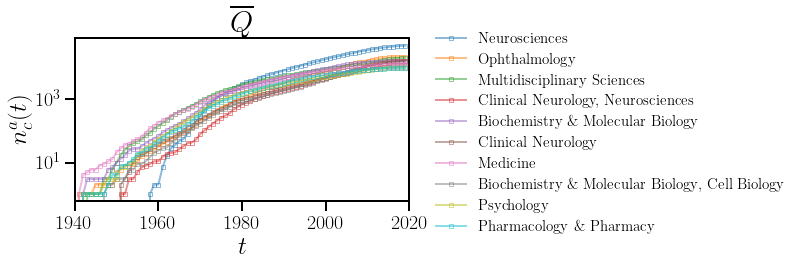

In [307]:
top = 10
fig = plt.figure(figsize=(6, 3))
axins = plt.axes()
colors = plt.cm.tab20.colors[::2]
by = 1940
step_xticks = 20
j = 0
for d in reversed(list(wos_domains_count['Qbar'].keys())[-top:]):
    if wos_domains_count['Qbar'][d] >= 5:
        linesize = 2
        markersize = 4
        alpha = 0.5
        axins.plot(np.arange(1940,2020), 
                       wos_domains['Qbar'][d][:-1], 
                       marker='s', mfc='none', linewidth=linesize,
                       color=colors[j], markersize=markersize, alpha=alpha, 
                       label=d.replace('&','\&'))
        j += 1
axins.set_ylabel(r'$n_c^a(t)$', fontsize=axisLabelSize)
axins.set_xlabel(r'$t$', fontsize=axisLabelSize)
axins.set_title(r'$\overline{Q}$', fontsize=titleSize)
#axins.set_ylim(bottom=15e-1, top=1e5)
axins.set_xlim(left=by,right=2020)
axins.set_yscale('log')
axins.set_xticks([i for i in range(by, 2021, step_xticks)])
axins.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
axins.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
axins.legend(bbox_to_anchor=(1.04, 1.12), ncol=1, fontsize=legendSize-5, frameon=False)
#plt.savefig(f'{path_output}cumulnb_authors_disciplines_first_year_Qbar.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 7 - Sankey diagrams for disciplinary trajectories of the authors within each quartile

For characterizing the disciplinary trajectories of the author, we need all the papers of the authors in order to get the set of disciplines characterizing their entire respective careers, as done for their first year of publication. Here some papers could have been published in journals that are not referenced in WoS, so we discard them for drawing such disciplinary combinations. 

In [12]:
papers_years = pd.concat([allpapers_Ql0[['id','publicationYear','wos_domains_agg']],allpapers_Ql2[['id','publicationYear','wos_domains_agg']]]).rename(columns={'id':'paperId'})
authors_years_wos = pd.merge(allAuthors_Ql0_papers, papers_years, on='paperId', how='left')[['authorId','publicationYear','wos_domains_agg']]
authors_years_wos.dropna(subset='publicationYear', inplace=True)
authors_years_wos['publicationYear'] = authors_years_wos['publicationYear'].astype(int)
authors_years_wos

,authorId,publicationYear,wos_domains_agg
0,2951562659,2012,"[Astronomy & Astrophysics, Physics]"
1,2535012878,2004,-1
2,2482451074,2004,-1
3,2060325654,2000,-1
4,2746639708,2001,-1
...,...,...,...
51964242,2768276645,2020,[Gastroenterology & Hepatology]
51964243,2328000574,2020,[Gastroenterology & Hepatology]
51964244,2653064050,2020,"[Oncology, Medicine]"
51964245,2831405835,2020,"[Materials Science, Engineering]"


In [13]:
authors_wos = authors_years_wos.groupby(['authorId','publicationYear']).agg(list).reset_index()
authors_wos.drop_duplicates(subset='authorId', inplace=True)
authors_wos['nb_papers_1st_year'] = authors_wos['wos_domains_agg'].apply(lambda x: len(x))

(array([5.69783e+05, 1.93683e+05, 7.25300e+04, 2.75630e+04, 1.13850e+04,
        5.23300e+03, 2.54300e+03, 1.30200e+03, 6.99000e+02, 3.94000e+02,
        2.97000e+02, 2.01000e+02, 9.40000e+01, 7.80000e+01, 4.60000e+01,
        3.50000e+01, 4.30000e+01, 1.70000e+01, 1.10000e+01, 1.60000e+01,
        1.40000e+01, 1.30000e+01, 1.00000e+01, 7.00000e+00, 1.00000e+01,
        4.00000e+00, 6.00000e+00, 5.00000e+00, 6.00000e+00, 3.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 3.00000e+00,
        3.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

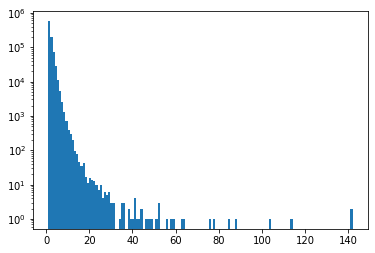

In [35]:
a = authors_wos[authors_wos['authorId'].isin(authorsInPapers_sub['authorId'])]
plt.hist(a['nb_papers_1st_year'],bins=max(a['nb_papers_1st_year']), log=True)

In [40]:
len(a[a['nb_papers_1st_year'].isin([1])])/len(a)

0.6430422289786181

In [55]:
authors_wos = authors_years_wos[['authorId','wos_domains_agg']]
authors_wos = authors_wos.explode('wos_domains_agg')
authors_wos = authors_wos[authors_wos['wos_domains_agg']!=-1]
authors_wos = authors_wos.explode('wos_domains_agg')
authors_wos = authors_wos.groupby('authorId').agg(list).reset_index()
authors_wos['wos_domains_agg'] = authors_wos['wos_domains_agg'].apply(lambda x: ', '.join(sorted(set(x))))
authors_wos['wos_domains_agg'] = authors_wos['wos_domains_agg'].apply(lambda x: x.replace('&','\&'))

In [90]:
authorsInPaper_sub = pd.merge(authorsInPapers_sub,authors_wos,on='authorId',how='left')

/tmp/ipykernel_7595/1264411378.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x
/tmp/ipykernel_7595/1264411378.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: x.replace('&','\&'))
/tmp/ipykernel_7595/1264411378.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

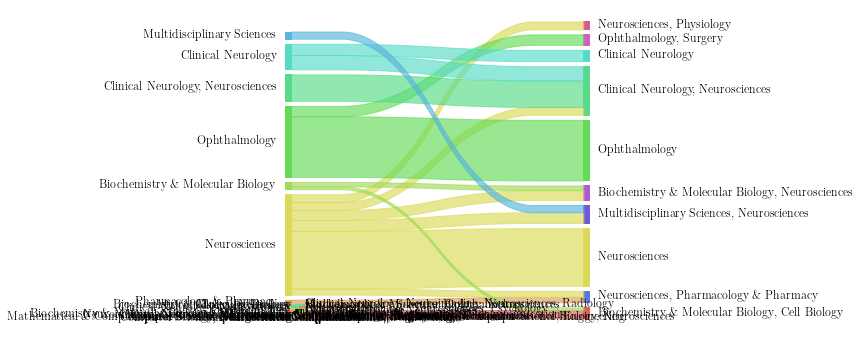

In [93]:
keys = ['$Q_0$','$Q_1$','$Q_2$','Qbar']
for q in [-1,0,1,2]:
    if q!=2:
        top = 10
        aspect = 22
    else:
        top = 6
        aspect = 22
    authors_q = authorsInPapers_sub[(authorsInPapers_sub['quartile']==q)
                                    & (authorsInPapers_sub['deltaYear']>=2)]
    authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x 
                                                                                            if p!=-1 for d in p]))))
    authors_q = authors_q[authors_q['wos_begin'].isin([i for i in list(wos_domains_count[keys[q]]) if i!=''][-top:])]
    authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: x.replace('&','\&'))
    g = Counter(authors_q['wos_domains_agg'])
    disc_career = [i for i in list({k:g[k] for k in sorted(g, key=g.get)}.keys()) if i!=''][-top:]
    authors_q = authors_q[authors_q['wos_domains_agg'].isin(disc_career)]
    '''
    authors_q['count'] = 1
    authors_q = authors_q[['wos_begin','wos_domains_agg','count']].groupby(['wos_begin','wos_domains_agg']).sum().reset_index()
    authors_q = authors_q.sort_values('count').reset_index()
    authors_q = authors_q.loc[authors_q.index[-10:],:]
    '''
    sankey.sankey(authors_q['wos_begin'], authors_q['wos_domains_agg'], 
                  #leftWeight=authors_q['count'], rightWeight=authors_q['count'],
                  aspect=aspect, colorDict=None, fontsize=12)

#### Plot the Sankey diagrams one by one instead

/tmp/ipykernel_7595/1760866254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x
/tmp/ipykernel_7595/1760866254.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: x.replace('&','\&'))


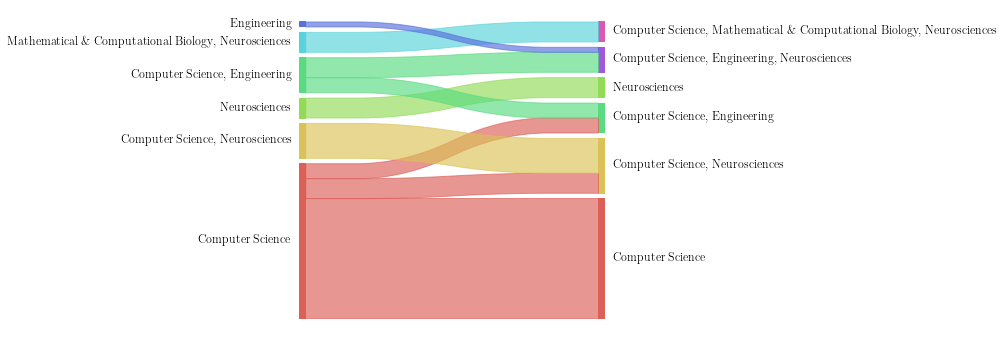

In [193]:
q = 2
if q!=2:
    top = 10
    aspect = 22
else:
    top = 6
    aspect = 22
authors_q = authorsInPapers_sub[(authorsInPapers_sub['quartile']==q)
                                & (authorsInPapers_sub['deltaYear']>=2)]
authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x 
                                                                                            if p!=-1 for d in p]))))
authors_q = authors_q[authors_q['wos_begin'].isin([i for i in list(wos_domains_count[keys[q]]) if i!=''][-top:])]
authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: x.replace('&','\&'))
g = Counter(authors_q['wos_domains_agg'])
disc_career = [i for i in list({k:g[k] for k in sorted(g, key=g.get)}.keys())if i!=''][-top:]
authors_q = authors_q[authors_q['wos_domains_agg'].isin(disc_career)]
sankey.sankey(authors_q['wos_begin'], authors_q['wos_domains_agg'], 
                  #leftWeight=authors_q['count'], rightWeight=authors_q['count'],
                  aspect=aspect, colorDict=None, fontsize=12)

## 7.1 - Compute the share of people in each quartile having a final profile containing *Neurosciences*, *Clinical Neurology* or *Neuroimaging*, from the authors selected with the top 10 originating JSCs

In [239]:
for q in [-1,0,1,2]:
    authors_q = authorsInPapers_sub[(authorsInPapers_sub['quartile']==q)
                                    & (authorsInPapers_sub['deltaYear']>=2)]
    authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x 
                                                                                            if p!=-1 for d in p]))))
    authors_q = authors_q[authors_q['wos_begin'].isin([i for i in list(wos_domains_count[keys[q]]) if i!=''][-top:])]
    n = 0
    for d in authors_q['wos_domains_agg'].dropna():
        if len(re.findall('Neurosciences|Clinical Neurology|Neuroimaging',d))>0:
            n += 1
    print(q, len(authors_q))
    print(n/len(authors_q))

/tmp/ipykernel_7595/3933546299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_q['wos_begin'] = authors_q['wos_begin'].apply(lambda x: ', '.join(sorted(set([d for p in x


-1 134056
0.7686563824073521
0 25411
0.7844240683168706
1 734
0.45231607629427795
2 93
0.41935483870967744


# 7bis - Redo the previous analysis by considering a discplinary score and take the most probable one

A little problem in our calculation: if we do the ponderation with one journal having two categories, we loose the influence/weight of the two categories involved in this journal. Getting rid of it make come back to the previous situation for the disciplinary background.

For the whole career, we could apply it but it adds too much difficulties for the paper, especially for the authors having very short career (< 5 years) and a low number of papers (more than 3 but no more than 5 for example).

The goal of such a study is to capture the potential disciplinary diversity, which we choose to make occuring equally in our dataset. 

## 7bis.1 -  Select the authors depending on their first year of publication and their career
- keep only people that have begun to publish at least in 1940 having a duration of career up to 50 years
- Period up to 2019
- keep only people that have at least 3 publications: boarder effect in $f_{AI}=1$ whose high propensity could be explained by authors with only one publication, such as interns, post-doc, PhD students, etc.

In [12]:
authorsInPapers_sub = authorsInPapers[(authorsInPapers['beginYear']>=1940) &
                                      (authorsInPapers['deltaYear']<=50) &
                                      (authorsInPapers['nb_publi_all']>=3)]

In [16]:
papers_years = pd.concat([allpapers_Ql0[['id','queryLevel','publicationYear','idJournal','wos_domains_agg']],
                          allpapers_Ql2[['id','queryLevel','publicationYear','idJournal','wos_domains_agg']]]).rename(columns={'id':'paperId'})

In [19]:
import gc
del allpapers_Ql0, allpapers_Ql2
gc.collect()

881

## 7bis.2 - Disciplinary background

Here we consider the two first year of publications to consider a disciplinary background

In [ ]:
authorsInPapers_sub['wos_begin'] = authorsInPapers_sub['wos_begin'].apply(lambda x: eval(x))

In [195]:
main_discipline_background = []
for a,w in zip(tqdm(authorsInPapers_sub['authorId']), authorsInPapers_sub['wos_begin']):
    d = [(i,1/(len(p)*len(w))) for p in w if p!=-1 for i in p]
    if len(d)==0:
        main_d = -1
    elif len(d)==1:
        main_d = d[0][0]
    else:
        d_sub = np.array([i[0] for i in d])
        score = np.array([i[1] for i in d])
        new_d = []
        for i in set(d_sub):
            ind_where = np.where(d_sub==i)[0]
            new_d.append((i,sum(score[ind_where])))
        new_score = np.array(new_d)[:,1]
        max_ind = np.where(new_score==max(new_score))[0]
        main_d = ', '.join(sorted(d_sub[max_ind]))
    main_discipline_background.append((a,main_d))

100%|████████████████████████████████| 886074/886074 [00:09<00:00, 96531.91it/s]


In [198]:
authorsInPapers_sub = pd.merge(authorsInPapers_sub,
                               pd.DataFrame(main_discipline_background, columns=['authorId','main_wos_begin']),
                               on='authorId',
                               how='left')

In [199]:
keys = ['$\overline{Q}$','$Q_0$','$Q_1$','$Q_2$']
wos_domains = {k:{} for k in keys}
for q in [-1,0,1,2]:
    authors_q = authorsInPapers_sub[authorsInPapers_sub['quartile']==q]
    alldomains = set(authors_q['main_wos_begin'])-{-1}
    wos_domains[keys[q+1]] = {d:[0] for d in alldomains}
    # homogenize the big categories encountered
    for y in range(1940,2020):
        domains_y = Counter(authors_q[(authors_q['beginYear']==y)&
                                      (authors_q['main_wos_begin']!=-1)]['main_wos_begin'])
        for d in alldomains:
            if d in domains_y:
                wos_domains[keys[q+1]][d].append(wos_domains[keys[q+1]][d][-1] + domains_y[d])
            else:
                wos_domains[keys[q+1]][d].append(wos_domains[keys[q+1]][d][-1])

In [200]:
# sort the counters taking the values at the end of the period, ie. 2019
wos_domains_count = {k:{l:wos_domains[k][l][-1] for l in wos_domains[k]} for k in keys}
for k in wos_domains_count:
    wos_domains_count[k] = {l:wos_domains_count[k][l] for l in sorted(wos_domains_count[k], key=wos_domains_count[k].get)}

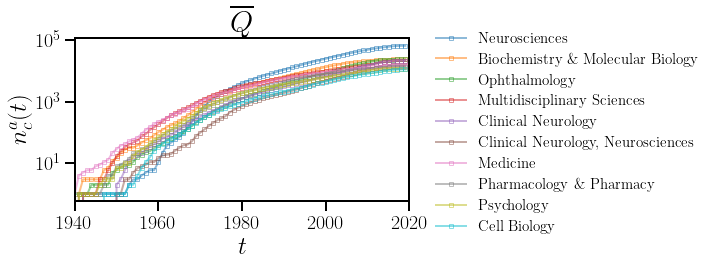

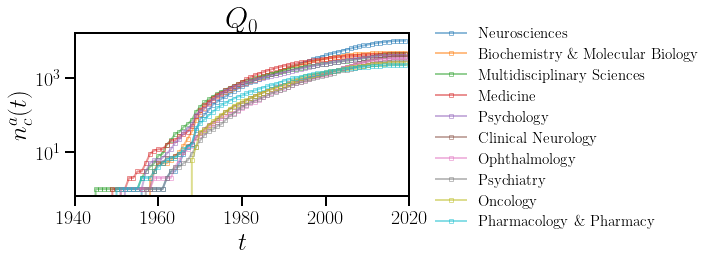

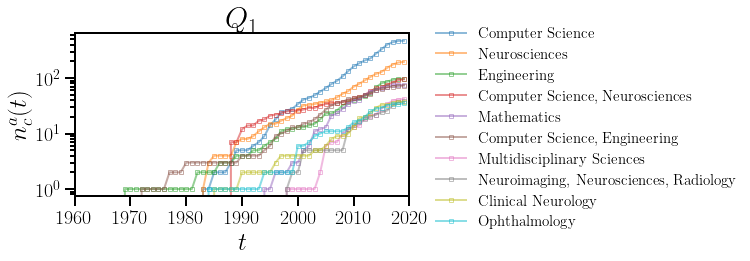

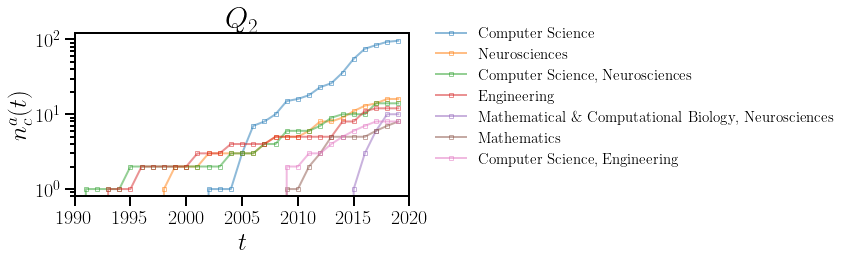

In [201]:
top = 10
l = 0
for k in wos_domains_count:
    fig = plt.figure(figsize=(6, 3))
    axins = plt.axes()
    colors = plt.cm.tab20.colors[::2]
    j = 0
    if k in ['$Q_0$','$\overline{Q}$']:
        by = 1940
        step_xticks = 20
    elif k == '$Q_1$':
        by = 1960
        step_xticks = 10
    elif k == '$Q_2$':
        by = 1990
        step_xticks = 5
    for d in reversed(list(wos_domains_count[k].keys())[-top:]):
        if wos_domains_count[k][d] >= 5:
            '''
            if d in ['Neurosciences','Multidisciplinary Sciences','Computer Science',
                     'Computer Science, Neurosciences', 'Computer Science, Engineering']:
                linesize = 3
                markersize = 5
                alpha = 1
            else:
                linesize = 2
                markersize = 3
                alpha = 0.5
            '''
            linesize = 2
            markersize = 4
            alpha = 0.5
            axins.plot(np.arange(1940,2020), 
                       wos_domains[k][d][1:], 
                       marker='s', mfc='none', linewidth=linesize,
                       color=colors[j], markersize=markersize, alpha=alpha, 
                       label=d.replace('&','\&'))
            j += 1
    axins.set_ylabel(r'$n_c^a(t)$', fontsize=axisLabelSize)
    axins.set_xlabel(r'$t$', fontsize=axisLabelSize)
    axins.set_title(k, fontsize=titleSize)
    #axins.set_ylim(bottom=1)
    axins.set_xlim(left=by,right=2020)
    axins.set_yscale('log')
    axins.set_xticks([i for i in range(by, 2021, step_xticks)])
    axins.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
    axins.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
    axins.legend(bbox_to_anchor=(1.04, 1.12), ncol=1, fontsize=legendSize-5, frameon=False)
    # plt.savefig(f'{path_output}cumulnb_authors_disciplines_first_year_Q{l}.pdf', format='pdf', bbox_inches='tight')
    l += 1
    plt.show()

## 7bis.3 - For the Sankey Diagram, redo it with the authors that have at least a career of three years

In [183]:
authors_paperYear_wos = pd.merge(allAuthors_Ql0_papers[allAuthors_Ql0_papers['authorId'].isin(authorsInPapers_sub['authorId'])],
                                 papers_years,
                                 on='paperId',
                                 how='inner')
authors_paperYear_wos = authors_paperYear_wos[['authorId','wos_domains_agg']].groupby('authorId').agg(list).reset_index()

In [202]:
main_discipline_career = []
for a,w in zip(tqdm(authors_paperYear_wos['authorId']), authors_paperYear_wos['wos_domains_agg']):
    d = [(i,1/(len(p)*len(w))) for p in w if p!=-1 for i in p]
    if len(d)==0:
        main_d = -1
    elif len(d)==1:
        main_d = d[0][0]
    else:
        d_sub = np.array([i[0] for i in d])
        score = np.array([i[1] for i in d])
        new_d = []
        for i in set(d_sub):
            ind_where = np.where(d_sub==i)[0]
            new_d.append((i,sum(score[ind_where])))
        new_score = np.array(new_d)[:,1]
        max_ind = np.where(new_score==max(new_score))[0]
        main_d = ', '.join(set(d_sub[max_ind]))
    main_discipline_career.append((a,main_d))

100%|█████████████████████████████████| 886074/886074 [01:56<00:00, 7622.04it/s]


In [203]:
authorsInPapers_sub = pd.merge(authorsInPapers_sub,
                               pd.DataFrame(main_discipline_career, columns=['authorId','main_wos_career']),
                               on='authorId',
                               how='left')

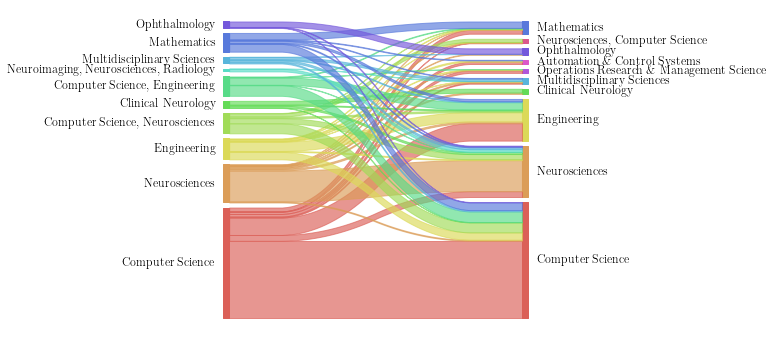

In [223]:
keys = ['$\overline{Q}$','$Q_0$','$Q_1$','$Q_2$']
q = 1
if q!=2:
    top = 10
    aspect = 22
else:
    top = 6
    aspect = 22
authors_q = authorsInPapers_sub[(authorsInPapers_sub['quartile']==q)
                                & (authorsInPapers_sub['deltaYear']>=2)]
authors_q = authors_q[authors_q['main_wos_begin'].isin([i for i in list(wos_domains_count[keys[q+1]]) if i!=-1][-top:])]
authors_q['main_wos_begin'] = authors_q['main_wos_begin'].apply(lambda x: x.replace('&','\&'))
authors_q['main_wos_career'] = authors_q['main_wos_career'].apply(lambda x: x.replace('&','\&'))
g = Counter(authors_q['main_wos_career'])
disc_career = [i for i in list({k:g[k] for k in sorted(g, key=g.get)}.keys()) if i!=-1][-top:]
authors_q = authors_q[authors_q['main_wos_career'].isin(disc_career)]

'''
authors_q['count'] = 1
authors_q = authors_q[['main_wos_begin','main_wos_career','count']].groupby(['main_wos_begin','main_wos_career']).sum().reset_index()
authors_q = authors_q.sort_values('count').reset_index()
authors_q = authors_q.loc[authors_q.index[-50:],:]
'''

sankey.sankey(authors_q['main_wos_begin'], authors_q['main_wos_career'], 
              #leftWeight=authors_q['count'], rightWeight=authors_q['count'],
              aspect=aspect, colorDict=None, fontsize=12)

## 7bis.4 - Compute the share of people in each quartile having a final profile containing *Neurosciences*, *Clinical Neurology* or *Neuroimaging*, from the authors selected with the top 10 originating JSCs

In [226]:
for q in [-1,0,1,2]:
    authors_q = authorsInPapers_sub[(authorsInPapers_sub['quartile']==q)
                                    & (authorsInPapers_sub['deltaYear']>=2)]
    authors_q = authors_q[authors_q['main_wos_begin'].isin([i for i in list(wos_domains_count[keys[q+1]]) if i!=''][-top:])]
    n = 0
    for d in authors_q['main_wos_career'].dropna():
        if len(re.findall('Neurosciences|Clinical Neurology|Neuroimaging',d))>0:
            n += 1
    print(q, len(authors_q))
    print(n/len(authors_q))

-1 210421
0.3861306618635973
0 42680
0.28563730084348643
1 956
0.24476987447698745
2 105
0.2


---

# 8 - Coreness of the AI practitioners within the global neuroscientific collaboration network

In [4]:
import cpnet
from scipy.sparse import csr_matrix
import json

In [10]:
path_input = r'/home/sylvain/DOCTORAT/PUBLICATIONS/2_AI_EpistemicIntegration_SocialSegregation/dataset_Zenodo/'
path_input_2 = r'/home/sylvain/DOCTORAT/DATA/microsoft_academic/corpus/neuroscience/database/updated/QL0+QL2+QL3_all_for_CollabNetwork/filtered_data_for_analyzes_ALL_PUBLIS/'

In [14]:
# add weights
def aggregate(temporal_collab_network):
    cn = {}
    for i,j,w in tqdm(temporal_collab_network[['author1','author2','w']].values):
        if (i,j) in cn:
            cn[(i,j)] += w
        elif (j,i) in cn:
            cn[(j,i)] += w
        else:
            cn[(i,j)] = w
    cn = pd.DataFrame.from_records([(i,j,k) for ((i,j),k) in cn.items()], columns=['author1','author2','w'])
    return cn

def get_sparse_matrix_from_edgeList_DataFrame(edges, label_source, label_target, label_value, directed):
    
    # build the mapping function of the nodes
    map_node = {j:i for i,j in enumerate(set(edges[label_source])|set(edges[label_target]))}
    # print(map_node)
    N = len(map_node)
    
    # build the correspondance matrix with row's and column's vectors
    # don't forget to add the symmetric links
    # here we consider that an author cannot figure twice, so no selfloop
    if directed:
        matrix = np.array([[map_node[i],map_node[j],k] for i,j,k in edges.values])
    else:
        matrix = np.array([[map_node[i],map_node[j],k] for i,j,k in edges.values]+[[map_node[j],map_node[i],k] for i,j,k in edges.values])
    rows, columns, values = matrix[:,0], matrix[:,1], matrix[:,2]

    return map_node, csr_matrix((values, (rows, columns)), shape=(N,N))

In [15]:
collabNet = pd.read_csv(f'{path_input}collabNet.csv', sep=';')
collabNet_timeagg = aggregate(collabNet)
authorsInPapers = pd.read_csv(f'{path_input}collabNet_nodes.csv', sep=';')
authorsInPapers_sub = authorsInPapers[(authorsInPapers['nb_publi_all']>=3) &
                                      (authorsInPapers['deltaYear']<=50) &
                                      (authorsInPapers['beginYear']>=1940)]

100%|███████████████████████████| 12637315/12637315 [00:19<00:00, 642906.17it/s]


In [16]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

In [17]:
AIauthors = authorsInPapers_sub[authorsInPapers_sub['AIscore_all']>0]['authorId']

## 8.1 - Using the algorithms proposed by the library `cpnet`

### 8.1.1 - Into the whole network between 1970 and 2020

In [12]:
map_node, adj_matrix = get_sparse_matrix_from_edgeList_DataFrame(sub_collabNet_timeagg,'author1','author2','w',directed=False)

In [13]:
AI_map_node = [map_node[k] for k in AIauthors if k in map_node.keys()]

In [30]:
len(AIauthors)-len(AI_map_node)

1919

In [ ]:
# compute the coreness with Rossa's algorithm and save the qs-test

algo = cpnet.Surprise() #cpnet.Rossa()
algo.detect(adj_matrix)

In [ ]:
coreness_node = rossa.get_coreness()
coreness_AInode = [coreness_node[i] for i in AI_map_node]
mean_AIcoreness = np.mean(coreness_AInode)
std_AIcoreness = np.std(coreness_AInode)
sem_AIcoreness = np.std(coreness_AInode)/np.sqrt(len(AI_map_node))
print(mean_AIcoreness, std_AIcoreness, sem_AIcoreness)
print(qs_test)

### 8.1.2 - In time

In [13]:
sub_collabNet = collabNet[collabNet['author1'].isin(authorsInPapers_sub['authorId']) & collabNet['author2'].isin(authorsInPapers_sub['authorId'])]

In [86]:
qs_test = []
# coreness = {k:[] for k in authorsInPapers_sub['authorId']}

mean_AIcoreness = []
std_AIcoreness = []
sem_AIcoreness = []

for year in tqdm(range(1970,2020)):
    
    sub_cn_y = sub_collabNet[sub_collabNet['year']==year][['author1','author2','w']]
    
    map_node, adj_matrix = get_sparse_matrix_from_edgeList_DataFrame(sub_cn_y,'author1','author2','w',False)
    inverse_map_node = {j:i for i,j in map_node.items()}
    
    mapdf = pd.DataFrame(map_node.items())
    sub_cn_y = pd.merge(sub_cn_y,mapdf,left_on='author1',right_on=0,how='left')
    sub_cn_y = pd.merge(sub_cn_y,mapdf,left_on='author1',right_on=0,how='left')
    G = nx.from_pandas_edgelist(sub_cn_y[['1_x','1_y','w']], source='1_x', target='1_y', edge_attr='w', create_using=nx.Graph, edge_key=None)
    
    algo = cpnet.Surprise()
    algo.detect(adj_matrix)
    c = algo.get_pair_id()
    x = algo.get_coreness()

    '''
    # run the statistical test to identify the statistically unisgnificant attribution of nodes to core and periphery
    print('Test begins')
    sig_c, sig_x, significant, p_values = cpnet.qstest(pair_id = c, 
                                                       coreness = x, 
                                                       G = G, 
                                                       cpa = algo, 
                                                       significance_level = 0.05, 
                                                       num_of_thread = 6)
    print('Test done')
    '''
    
    coreness_node = algo.get_coreness()
    
    coreness_AInode = [coreness_node[i] for i in coreness_node.keys() if inverse_map_node[i] in AIauthors]
    mean_AIcoreness.append(np.mean(coreness_AInode))
    std_AIcoreness.append(np.std(coreness_AInode))
    sem_AIcoreness.append(np.std(coreness_AInode)/np.sqrt(len(coreness_AInode)))
    
    break

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Test begins


/home/sylvain/.local/lib/python3.8/site-packages/cpnet/qstest.py:94: UserWarning: 'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.
  warnings.warn("'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.")
/home/sylvain/.local/lib/python3.8/site-packages/cpnet/qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
/home/sylvain/.local/lib/python3.8/site-packages/cpnet/utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),

  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/sylvain/.local/lib/python3.8/site-packages/cpnet/qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Test done


## 8.2 - Using the standard $k$-shell decomposition and the belonging to the giant component

In [9]:
import networkx as nx

In [10]:
G_filtered = nx.from_pandas_edgelist(sub_collabNet_timeagg, source='author1', target='author2', edge_attr='w', create_using=nx.Graph, edge_key=None)

### 8.2.1 - Unweighted version
TO REVISE!!!!

In [112]:
maxk = 50
coreness_AI = {}
for k in tqdm(range(maxk)):
    c = nx.k_shell(G_filtered, k=k, core_number=None)
    coreness_AI[k] = len(set(c.nodes)&set(AIauthors))
 # coreness = nx.core_number(G_filtered)

100%|███████████████████████████████████████████| 50/50 [31:13<00:00, 37.48s/it]


In [115]:
for k in tqdm(range(maxk,101)):
    c = nx.k_shell(G_filtered, k=k, core_number=None)
    coreness_AI[k] = len(set(c.nodes)&set(AIauthors))
 # coreness = nx.core_number(G_filtered)

100%|███████████████████████████████████████████| 51/51 [27:48<00:00, 32.72s/it]


In [116]:
sum(coreness_AI.values())

183264

In [117]:
d = []
for k in coreness_AI.keys():
    d += [k]*coreness_AI[k]

Text(0, 0.5, '$N_a^{AI}$')

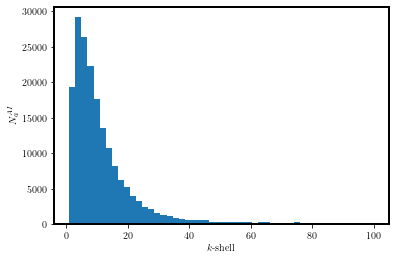

In [123]:
plt.hist(d,bins=50)
plt.xlabel(r'$k$-shell')
plt.ylabel(r'$N_a^{AI}$')

### 8.2.2 - Weighted version

In [30]:
max(dict(G_filtered.degree(weight='w')).values())

5863

In [174]:
def remove_shell(G_orig, core):
    G = G_orig.copy()
    core_nodes = []
    deg = G.degree(weight='w')
    remove = [n for n,d in deg if d<=core]
    G.remove_nodes_from(remove)
    core_nodes += remove
    while len(remove)>0:
        #print(remove)
        deg = G.degree(weight='w')
        remove = [n for n,d in deg if d<=core]
        G.remove_nodes_from(remove)
        core_nodes += remove
    return G, core_nodes

def kcore_number(G_orig,list_node):
    G = G_orig.copy()
    core_numbers = {}
    core = 0
    while (len(G.nodes)>0) | (core<=100):
        core += 1
        G, core_nodes = remove_shell(G, core)
        core_numbers.update({n:core for n in core_nodes if n in list_node})
        print(core)
    return core_numbers

def drop_zeros(a_list):
    return [i for i in a_list if i>0]

def log_binning(counter_dict,bin_count):
    
    # Returns a mean-log-binning, because the actual bins are flattened in log space,
    # thus a logarithmic bin could be composed of multiple real bins.
    # we thus must to average the values of the frequency in each log bin to have a smooth distibution

    max_x = np.log10(max(counter_dict.keys()))
    max_y = np.log10(max(counter_dict.values()))
    max_base = max([max_x,max_y])

    min_x = np.log10(min(drop_zeros(counter_dict.keys())))

    bins = np.logspace(min_x,max_base,num=bin_count)

    bin_means_y = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.values()))[0]/np.histogram(list(counter_dict.keys()),bins)[0])
    bin_means_x = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.keys()))[0]/np.histogram(list(counter_dict.keys()),bins)[0])

    return bin_means_x,bin_means_y

In [13]:
coreness_AI_weighted = kcore_number(G_filtered,list(AIauthors))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [27]:
with open(f'{path_input_2}core_number_AIpapers.json', 'w') as f:
    json.dump(coreness_AI_weighted, f)

In [24]:
with open(f'{path_input_2}core_number_AI_authors_WEIGHTED.json', 'r') as f:
    coreness_AI_weighted = json.load(f)
coreness_AI_weighted = {int(k):coreness_AI_weighted[k] for k in coreness_AI_weighted.keys()}

In [18]:
q0 = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>0) & (authorsInPapers_sub['AIscore_all']<0.5)]['authorId']
q1 = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']>=0.5) & (authorsInPapers_sub['AIscore_all']<1)]['authorId']
q2 = authorsInPapers_sub[(authorsInPapers_sub['AIscore_all']==1)]['authorId']

In [26]:
coreness_AI_weighted_q0 = {k:coreness_AI_weighted[k] for k in set(coreness_AI_weighted.keys())&set(q0)}
coreness_AI_weighted_q1 = {k:coreness_AI_weighted[k] for k in set(coreness_AI_weighted.keys())&set(q1)}
coreness_AI_weighted_q2 = {k:coreness_AI_weighted[k] for k in set(coreness_AI_weighted.keys())&set(q2)}

In [27]:
print(0,np.quantile(list(coreness_AI_weighted_q0.values()),q=[0,0.25,0.5,0.75,1]))
print(0,np.quantile(list(coreness_AI_weighted_q0.values()),q=[0.9]))
print(1,np.quantile(list(coreness_AI_weighted_q1.values()),q=[0,0.25,0.5,0.75,1]))
print(2,np.quantile(list(coreness_AI_weighted_q2.values()),q=[0,0.25,0.5,0.75,1]))

0 [  1.   5.  10.  23. 770.]
0 [51.]
1 [  1.   2.   4.   6. 146.]
2 [ 1.  2.  3.  4. 52.]


In [217]:
p = Counter(coreness_AI_weighted_q0.values())

In [220]:
p[770]/len(coreness_AI_weighted_q0)

0.0016673107712692542

#### Plot with standard binning

In [255]:
m = max(coreness_AI_weighted_q1.values())
m

146

In [296]:
bins = np.linspace(1,max(coreness_AI_weighted_q1.values()),50)

In [297]:
histo_q0 = np.histogram(list(coreness_AI_weighted_q0.values()), bins)[0]/len(coreness_AI_weighted_q0)
histo_q1 = np.histogram(list(coreness_AI_weighted_q1.values()), bins)[0]/len(coreness_AI_weighted_q1)
histo_q2 = np.histogram(list(coreness_AI_weighted_q2.values()), bins)[0]/len(coreness_AI_weighted_q2)

In [298]:
len(histo_q0)

49

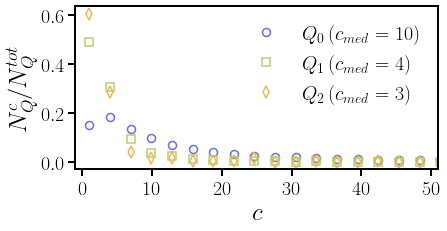

In [311]:
cmap = plt.cm.tab20b.colors
ig = plt.figure(figsize=(6.5, 3))
ax = plt.axes()
x = np.arange(1,m+1)
ax.plot(bins[:-1], histo_q0, 
        marker='o',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[2], markersize=8, alpha=1, label=r'$Q_0\,(c_{med}=10)$')
ax.plot(bins[:-1], histo_q1, 
        marker='s',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[6], markersize=8, alpha=1, label=r'$Q_1\,(c_{med}=4)$')
ax.plot(bins[:-1], histo_q2, 
        marker='d',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[10], markersize=8, alpha=1, label=r'$Q_2\,(c_{med}=3)$')
ax.set_xlabel(r'$c$', fontsize=axisLabelSize)
ax.set_ylabel(r'$N^c_Q/N^{tot}_Q$', fontsize=axisLabelSize)
#ax.vlines(10**2, 10**-4, 10**7, colors='red', linestyles='--')
#ax.set_ylim(1,1e5)
ax.set_xlim(left=-1,right=51)
ax.set_xticks([i*10 for i in range(6)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
ax.legend(loc='upper right', ncol=1, fontsize=legendSize, frameon=False)
plt.savefig(f'{path_input}kshell_distrib_Binned_FilteredDataset_ALLQUARTILES.pdf', format='pdf', bbox_inches='tight')

#### Plot with log-binning

In [36]:
x_original,y_original = log_binning(Counter(coreness_AI_weighted.values()),50)

/tmp/ipykernel_277870/2799371028.py:40: RuntimeWarning: invalid value encountered in true_divide
  bin_means_y = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.values()))[0]/np.histogram(list(counter_dict.keys()),bins)[0])
/tmp/ipykernel_277870/2799371028.py:41: RuntimeWarning: invalid value encountered in true_divide
  bin_means_x = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.keys()))[0]/np.histogram(list(counter_dict.keys()),bins)[0])


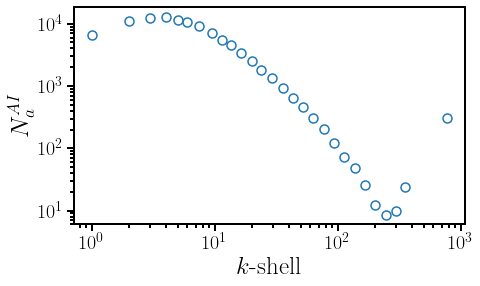

In [81]:
cmap = plt.cm.tab20.colors
ig = plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(x_original, y_original, marker='o',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[0], markersize=9, alpha=1)
ax.set_xlabel(r'$k$-shell', fontsize=axisLabelSize)
ax.set_xscale('log')
ax.set_ylabel(r'$N^{AI}_a$', fontsize=axisLabelSize)
ax.set_yscale('log')
#ax.vlines(10**2, 10**-4, 10**7, colors='red', linestyles='--')
#ax.set_ylim(1,1e5)
#ax.set_xlim(0.6,1e5)
#ax.set_xticks([10**i for i in range(6)], [10**i for i in range(6)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
plt.savefig(f'{path_input}kshell_distrib_LogBinned_FilteredDataset_ALLQUARTILES.pdf', format='pdf', bbox_inches='tight')

In [172]:
x_original_q0, y_original_q0 = log_binning(Counter(coreness_AI_weighted_q0.values()),50)
x_original_q1, y_original_q1 = log_binning(Counter(coreness_AI_weighted_q1.values()),50)
x_original_q2, y_original_q2 = log_binning(Counter(coreness_AI_weighted_q2.values()),50)

/tmp/ipykernel_277870/2799371028.py:40: RuntimeWarning: invalid value encountered in true_divide
  bin_means_y = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.values()))[0]/np.histogram(list(counter_dict.keys()),bins)[0])
/tmp/ipykernel_277870/2799371028.py:41: RuntimeWarning: invalid value encountered in true_divide
  bin_means_x = (np.histogram(list(counter_dict.keys()),bins,weights=list(counter_dict.keys()))[0]/np.histogram(list(counter_dict.keys()),bins)[0])


In [329]:
y_original

array([6.52000000e+03,            nan,            nan, 1.11060000e+04,
                  nan, 1.24750000e+04,            nan, 1.28580000e+04,
       1.13990000e+04, 1.05690000e+04, 9.03200000e+03, 6.98800000e+03,
       5.52750000e+03, 4.51800000e+03, 3.36050000e+03, 2.49966667e+03,
       1.80320000e+03, 1.33950000e+03, 9.24714286e+02, 6.47250000e+02,
       4.55500000e+02, 3.08333333e+02, 2.00933333e+02, 1.20944444e+02,
       7.21818182e+01, 4.80370370e+01, 2.60625000e+01, 1.23513514e+01,
       8.62500000e+00, 9.69767442e+00, 2.42142857e+01,            nan,
                  nan,            nan, 3.02000000e+02,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan])

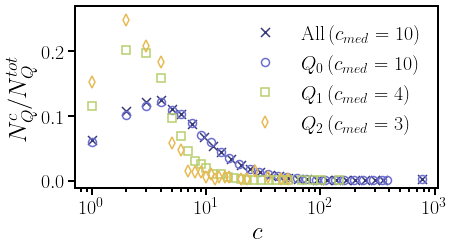

In [330]:
ig = plt.figure(figsize=(6.5, 3.35))

cmap = plt.cm.tab20b.colors
#colors = [cmap[18], cmap[2], cmap[6], cmap[10], cmap[14]]
ax = plt.axes()
ax.plot(x_original, y_original/np.nansum(y_original), marker='x',mfc='none', 
        markeredgewidth=1.5, label=r'All$\,(c_{med}=10)$',
        linewidth=0, color=cmap[0], markersize=9, alpha=1)
ax.plot(x_original_q0, y_original_q0/np.nansum(y_original_q0), 
        marker='o',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[2], markersize=8, alpha=1, label=r'$Q_0\,(c_{med}=10)$')
ax.plot(x_original_q1, y_original_q1/np.nansum(y_original_q1), 
        marker='s',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[6], markersize=8, alpha=1, label=r'$Q_1\,(c_{med}=4)$')
ax.plot(x_original_q2, y_original_q2/np.nansum(y_original_q2), 
        marker='d',mfc='none', markeredgewidth=1.5,
        linewidth=0, color=cmap[10], markersize=8, alpha=1, label=r'$Q_2\,(c_{med}=3)$')
ax.set_xlabel(r'$c$', fontsize=axisLabelSize)
ax.set_xscale('log')
ax.set_ylabel(r'$N^c_Q/N^{tot}_Q$', fontsize=axisLabelSize)
#ax.set_yscale('log')
#ax.vlines(10**2, 10**-4, 10**7, colors='red', linestyles='--')
ax.set_ylim(top=0.27)
#ax.set_xlim(0.6,1e5)
#ax.set_yticks([0,0.25,0.5,0.75,1])
ax.legend(loc='upper right', ncol=1, fontsize=legendSize, frameon=False)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
plt.savefig(f'{path_input}kshell_distrib_LogBinned_FilteredDataset_SPLITTEDQUARTILES_ALL.pdf', format='pdf', bbox_inches='tight')

In [31]:
coreness = [list(coreness_AI_weighted_q0.values()),
            list(coreness_AI_weighted_q1.values()),
            list(coreness_AI_weighted_q2.values())]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


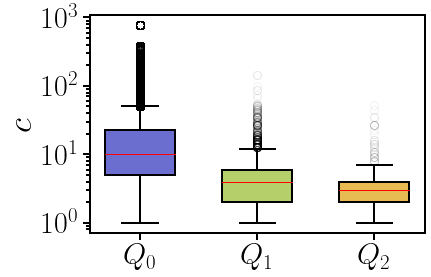

In [101]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
labels = ['$Q_0$','$Q_1$','$Q_2$']
linewidth = 2
cmap = plt.cm.tab20b.colors
colors = [cmap[2],cmap[6],cmap[10]]

bp = ax.boxplot(coreness, 
                   positions=np.array(range(len(coreness))),
                   patch_artist=True,
                   widths=0.6,
                   manage_ticks=False,
                   labels=labels)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(linewidth)
for w in bp['whiskers']:
    w.set_color('black')
    w.set_linewidth(linewidth)
for c in bp['caps']:
    c.set_color('black')
    c.set_linewidth(linewidth)
for f in bp['fliers']:
    #f.set_facecolor(None)
    f.set_linewidth(linewidth)
    f.set_color('grey')
    f.set_alpha(0.05)
    f.set_markersize(8)
for m in bp['medians']:
    m.set_color('red')
    m.set_linewidth(1)
'''
ax.plot(np.arange(0,len(coreness),1),
        [np.mean(q) for q in coreness], 
        'd', markersize=8, color='black', markerfacecolor='white')
'''
ax.set_ylabel(r'$c$', fontsize=axisLabelSize+10)
#yticks = np.arange(0,+1,3)
#ax.set_ylim(top=18)
ax.set_yscale('log')
ax.set_yticks([1,10,100,1000], [r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=axisLabelSize+5)
ax.set_xticks(np.array(range(len(coreness))), labels, fontsize=axisLabelSize+5)
ax.tick_params(which='major', length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
ax.legend(fontsize=20, ncol=2, frameon=False, loc='upper left')
plt.savefig(f'{path_input}/kshell_boxPlot_LogBinned_FilteredDataset_SPLITTEDQUARTILES_ALL.pdf', format='pdf', bbox_inches='tight')

Results: The majority of the AI practitioners have core number $c$ that is very low compared to the attained number in the long tail, thus assessing that the AI practitioners are in the periphery of the network. The maximum core number is 770. Some authors within $Q_0$ are in this value (a super-core, with 302 authors within this quartile, ie. 0,02\%), but not within the two other quartiles.

In [164]:
components = [i for i in nx.connected_components(G_filtered)]
l = [len(i) for i in components]
giant_comp = components[np.argmax(l)]

In [232]:
print(len(set(G_filtered.nodes)&set(q0)))
print(len(set(G_filtered.nodes)&set(q1)))
print(len(set(G_filtered.nodes)&set(q2)))

181130
4875
401


In [321]:
k = Counter(coreness_AI_weighted.values())
l = []
for i in k:
    l += [i]*k[i]

In [325]:
np.quantile(l,q=[0.25,0.5,0.75,1])

array([  5.,  10.,  22., 770.])

In [312]:
print(len(set(giant_comp)&set(q0))/len(set(G_filtered.nodes)&set(q0)))
print(1-len(set(giant_comp)&set(q1))/len(set(G_filtered.nodes)&set(q1)))
print(1-len(set(giant_comp)&set(q2))/len(set(G_filtered.nodes)&set(q2)))

0.9293049191188649
0.25989743589743586
0.27930174563591026


In [ ]:
# compute the mean core number of the Q_0 practitioners linking with Q_1 and Q_2 !!!

In [91]:
s = sub_collabNet_timeagg[sub_collabNet_timeagg['author1'].isin(set(q1)|set(q2))
                          | sub_collabNet_timeagg['author2'].isin(set(q1)|set(q2))]
q0_collabq1q2 = (set(s['author1'])|set(s['author2']))&set(q0)

In [103]:
print(np.quantile([coreness_AI_weighted_q0[k] for k in q0_collabq1q2],q=[0,0.25,0.5,0.75,1]))
print(np.max([coreness_AI_weighted_q0[k] for k in q0_collabq1q2]))
print(np.mean([coreness_AI_weighted_q0[k] for k in q0_collabq1q2]))
print(np.std([coreness_AI_weighted_q0[k] for k in q0_collabq1q2]))

[  1.   4.  10.  33. 770.]
770
32.392844235634264
60.19125036315826


# 9 - Affilitations of the AI practitioners

## 9.1 - MAG only
Here we study only the last known institution of each authors in 2020. Because of the change of the whole set of authors' ids, we cannot expect the affiliations trajectory of the actors considered in this study. Here we compute the share of all institutions per quartile.

In [148]:
authorsInPapers = pd.read_csv(f'{path_input}collabNet_nodes.csv', sep=';')
authorsInPapers_sub = authorsInPapers[(authorsInPapers['nb_publi_all']>=3) &
                                      (authorsInPapers['deltaYear']<=50) &
                                      (authorsInPapers['beginYear']>=1940)]

In [157]:
authorsInPapers_sub

,authorId,name_x,affiliation,queryLevel,nb_publi_neuro,AIscore_neuro,nb_publi_all,AIscore_all,beginYear,wos_begin,lastYear,wos_last,deltaYear,affiliation_id,name_y
0,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0.0,1.0,0.0,6,0.000000,1997.0,"[['Multidisciplinary Sciences'], ['Cell Biolog...",2012.0,[['Cell Biology']],15.0,121797337,Leiden University
1,2505675405,A. A. A. Manik J. Djelantik,193662353,0.0,2.0,0.0,11,0.000000,2016.0,"[['Neuroimaging', 'Psychiatry', 'Clinical Neur...",2019.0,"[['Social Issues', 'Social Sciences', 'Psychol...",3.0,193662353,Utrecht University
2,2991992674,A A Abdel-Latif,25041050,0.0,3.0,0.0,8,0.000000,1977.0,[['Biochemistry & Molecular Biology']],1991.0,"[['Cell Biology', 'Endocrinology & Metabolism'...",14.0,25041050,Georgia Regents University
3,2601140815,A. A. Adjei,1330342723,0.0,2.0,0.0,141,0.000000,1999.0,[['Oncology']],2019.0,"[['Biochemistry & Molecular Biology', 'Biophys...",20.0,1330342723,Mayo Clinic
4,2509231829,A A Ajayi,45711476,0.0,1.0,0.0,46,0.000000,1985.0,"[['Peripheral Vascular Diseases'], ['Pharmacol...",2015.0,[-1],30.0,45711476,Obafemi Awolowo University
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886069,344607885,Žiga Lesjak,153976015,0.0,1.0,0.0,6,0.166667,2014.0,[-1],2018.0,"[['Neurosciences', 'Computer Science'], -1]",4.0,153976015,University of Ljubljana
886070,251221162,Žiga Špiclin,153976015,0.0,2.0,0.0,41,0.102564,2007.0,"[['Instruments & Instrumentation', 'Engineerin...",2019.0,"[['Medical Informatics', 'Statistics & Probabi...",12.0,153976015,University of Ljubljana
886071,2638114372,Živa Majcen,153976015,0.0,1.0,0.0,3,0.000000,1972.0,[-1],1975.0,"[['Neurosciences', 'Pharmacology & Pharmacy'],...",3.0,153976015,University of Ljubljana
886072,645524173,Žofia Rádiková,207624831,0.0,1.0,0.0,14,0.000000,2006.0,[['Environmental Sciences']],2019.0,"[['Endocrinology & Metabolism', 'Nutrition & D...",13.0,207624831,Slovak Academy of Sciences


In [149]:
with open(f'/home/sylvain/DOCTORAT/DATA/microsoft_academic/corpus/neuroscience/database/updated/QL0/Affiliations_allAuthors_QL0.json', 'r') as f:
    affiliations = json.load(f)
affiliations = pd.DataFrame.from_records(affiliations)

In [150]:
authorsInPapers_sub = pd.merge(authorsInPapers_sub, affiliations[['affiliation_id','name']],
                               left_on='affiliation', right_on='affiliation_id', how='left')

In [153]:
q0_aff = Counter(authorsInPapers_sub[authorsInPapers_sub['authorId'].isin(q0)]['name_y'])
q0_aff = {k:q0_aff[k] for k in sorted(q0_aff, key=q0_aff.get, reverse=True)}
q1_aff = Counter(authorsInPapers_sub[authorsInPapers_sub['authorId'].isin(q1)]['name_y'])
q1_aff = {k:q1_aff[k] for k in sorted(q1_aff, key=q1_aff.get, reverse=True)}
q2_aff = Counter(authorsInPapers_sub[authorsInPapers_sub['authorId'].isin(q2)]['name_y'])
q2_aff = {k:q2_aff[k] for k in sorted(q2_aff, key=q2_aff.get, reverse=True)}

In [156]:
q2_aff

{nan: 49,
 'Huazhong University of Science and Technology': 6,
 'Dalian University of Technology': 5,
 'Hunan University': 5,
 'Bohai University': 5,
 'Xidian University': 5,
 'Northwestern Polytechnical University': 5,
 'Universit&#x00E9; de Montr&#x00E9;al': 5,
 'Zhejiang University': 5,
 'Chinese Academy of Sciences': 5,
 'China University of Mining and Technology': 5,
 'Xi&#039;an Jiaotong University': 5,
 'Northeastern University': 5,
 'Yanshan University': 4,
 'Southeast University': 4,
 'South China University of Technology': 4,
 'Liaoning Normal University': 4,
 'Arizona State University': 3,
 'Central South University': 3,
 'University of Toronto': 3,
 'Huaqiao University': 3,
 'Tianjin University': 3,
 'Chongqing Jiaotong University': 3,
 'Harbin Institute of Technology': 3,
 'Shenzhen University': 3,
 'Shanghai University': 3,
 'Nanjing University of Aeronautics and Astronautics': 3,
 'Nanjing University of Science and Technology': 3,
 'Instituto Polit&#x00E9;cnico Nacional'

## 9.2 - Redoing an extraction of the papers on OpenAlex
Here we can have the institutional trajectory of our authors by selecting only the authors metadata during the extraction

In [174]:
import os
import requests
os.chdir(r'/home/sylvain/DOCTORAT/DATA/OpenAlex/codes/github/')
import buildersOpenAlex as boa

In [214]:
papersNeuroAI = pd.read_csv(f'/home/sylvain/DOCTORAT/DATA/microsoft_academic/corpus/neuroscience/database/updated/QL0/filtered_data_for_analyzes/papersNeuroAI_minRef10_minImp10_from1970.csv', sep=';')
papersNeuro = pd.read_csv(f'/home/sylvain/DOCTORAT/DATA/microsoft_academic/corpus/neuroscience/database/updated/QL0/filtered_data_for_analyzes/papersNeuro_minRef10_minImp10_from1970.csv', sep=';')
allpapers_Ql0 = pd.concat([papersNeuroAI,papersNeuro]).reset_index(drop=True)
allpapers_Ql0['journal_title'] = [list(set(eval(i)))[0].title() if i!='-1' else -1 for i in allpapers_Ql0['journal_title']] # idem

In [243]:
k = sorted(list(set(allpapers_Ql0['journal_title'])-{-1}))
l = str()
for i in range(0,len(k),2):
    c = k[i].replace('&','\&')
    d = k[i+1].replace('&','\&')
    l += f'{c} & {d} \\\ '+'\n'

In [244]:
print(l)

Acs Chemical Neuroscience & Acta Neurobiologiae Experimentalis \\ 
Acta Neurologica Scandinavica & Acta Neuropathologica \\ 
Acta Neuropathologica Communications & Acta Neuropsychiatrica \\ 
Adaptive Behavior & Advances In Child Development And Behavior \\ 
Advances In Cognitive Psychology & Advances In The Study Of Behavior \\ 
Ageing Research Reviews & Alcohol \\ 
Alzheimers \& Dementia & Alzheimers Research \& Therapy \\ 
American Journal Of Alzheimers Disease And Other Dementias & American Journal Of Medical Genetics Part B-Neuropsychiatric Genetics \\ 
Anatomy \& Cell Biology & Annals Of Clinical And Translational Neurology \\ 
Annals Of Neurology & Annals Of Neurosciences \\ 
Annals Of The New York Academy Of Sciences & Annual Review Of Neuroscience \\ 
Aphasiology & Archives Of Neuroscience \\ 
Arquivos De Neuro-Psiquiatria & Asn Neuro \\ 
Audiology And Neuro-Otology & Autism Research \\ 
Autonomic Neuroscience-Basic \& Clinical & Basic And Clinical Neuroscience \\ 
Behavioral A

In [201]:
string_ids = ['|'.join(map(str,papersNeuroAI['id'][100*i:100*(i+1)]))
                 for i in range(1+len(papersNeuroAI['id'])//100)]

In [202]:
url_other = '&mailto=sylvain.fontaine@cnrs.fr&per-page=200&cursor='
folder = f'/home/sylvain/DOCTORAT/DATA/microsoft_academic/corpus/neuroscience/database/updated/QL0/filtered_data_for_analyzes/OpenAlex'
cursor = '*'

urlbase = f'https://api.openalex.org/works?filter=ids.mag:{string_ids[0]}'
url = urlbase + url_other + cursor

data=requests.get(url).json()

#build the dataframes and concatenate with the previous dataframes
boa.buildPaperMetadata(data).to_csv(f'{folder}/paper_metadata.csv',index=False)
boa.buildTitleAbstractDataframe(data).to_csv(f'{folder}/paper2titleabstract.csv',index=False,sep='\t')
boa.buildPaper2Author(data).to_csv(f'{folder}/paper2author.csv',index=False)
boa.buildAuthorInformation(data).to_csv(f'{folder}/author_metadata.csv',index=False)
boa.buildPaperConcepts(data).to_csv(f'{folder}/paper2concept.csv',index=False)
boa.buildPaperKeywords(data).to_csv(f'{folder}/paper2keyword.csv',index=False)
boa.buildPaperTopics(data).to_csv(f'{folder}/paper2topic.csv',index=False)
boa.buildPaperReferences(data).to_csv(f'{folder}/paper2references.csv',index=False)
boa.buildPaperGrants(data).to_csv(f'{folder}/paper2grants.csv',index=False)

for s in tqdm(string_ids[1:]):  
    urlbase = f'https://api.openalex.org/works?filter=ids.mag:{s}'
    try:
        url=urlbase + url_other + cursor
        data=requests.get(url).json()

        #build the dataframes and concatenate with the previous dataframes
        boa.buildPaperMetadata(data).to_csv(f'{folder}/paper_metadata.csv',index=False, mode='a', header=False)
        boa.buildTitleAbstractDataframe(data).to_csv(f'{folder}/paper2titleabstract.csv',index=False,sep='\t', mode='a', header=False)
        boa.buildPaper2Author(data).to_csv(f'{folder}/paper2author.csv',index=False, mode='a', header=False)
        boa.buildAuthorInformation(data).to_csv(f'{folder}/author_metadata.csv',index=False, mode='a', header=False)
        boa.buildPaperConcepts(data).to_csv(f'{folder}/paper2concept.csv',index=False, mode='a', header=False)
        boa.buildPaperKeywords(data).to_csv(f'{folder}/paper2keyword.csv',index=False, mode='a', header=False)
        boa.buildPaperTopics(data).to_csv(f'{folder}/paper2topic.csv',index=False, mode='a', header=False)
        boa.buildPaperReferences(data).to_csv(f'{folder}/paper2references.csv',index=False, mode='a', header=False)
        boa.buildPaperGrants(data).to_csv(f'{folder}/paper2grants.csv',index=False, mode='a', header=False)
    
    except (ConnectionError, ConnectionAbortedError, ConnectionRefusedError, ConnectionResetError, json.JSONDecodeError, KeyboardInterrupt):
        continue

100%|█████████████████████████████████████████| 263/263 [07:41<00:00,  1.75s/it]


In [203]:
p2a = pd.read_csv(f'{folder}/paper2author.csv')